In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import scipy
%matplotlib inline
from IPython.display import Image
import pandas as pd
import pystan
import AngStII_Bayes as bayes

# Generalisierte Lineare Modelle mit Bayes

- Kontinuierliche Variablen
    - eine Verteilung
    - mehrere Verteilungen
    - abhängige Verteilungen
- Lineares Modell 
    - Kausaler Zusammenhang
        - unabhängige Variablen (*predictors*)
        - abhängige Variable (*predicted*)
    - hierarchisches Modell
        - Kopplung
- Generalisiertes Lineares Modell
    - Link-Funktion (siehe Psychometrische Daten, Psignifit)

# Bayes-Statistik - kontinuierliche Daten

# Beispiel 1: Ein Intelligenztest *IQ*

### Daten - Zufallsvariable $Y$

- natürliche Streuung, Abweichungen, Rauschen, Meßfehler, ...
- Wahrscheinlichkeitsverteilung
$$\begin{aligned}
Y\; &\sim \mathcal{N}(\mu, \sigma^2) \\
\mathcal{E}(Y) &= \mu
\end{aligned}$$

### Modell mit Modellparametern

Beispielsweise Normalverteilung der IQ-Messwerte in der Bevölkerung
$$p(y|\mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\bigl({-\frac{(y-\mu)^2}{2\sigma^2}}\bigr)$$

### Likelihood für Datensatz 

- Versuche/Messwiederholungen sind voneinander unabhängig *i.i.d.*
- $D = \{y_i\}$
$$L = p(D|\mu,\sigma) = \prod_{i=1}^{N}p(y_i|\mu, \sigma) $$

## Satz von Bayes

$$p(\mu,\sigma|D) = \frac{p(D|\mu,\sigma)\, p(\mu, \sigma)}{\int_{\mu}\int_{\sigma} p(D|\mu,\sigma)\, p(\mu, \sigma)\;\mathrm{d}\sigma\;\mathrm{d}\mu}$$

### Prior

Vorwissen, Theorie, allgemein akzeptiert, ...

Beispielsweise:
- $\mu$: Mittelwert bei 100 (IQ Definition); streut zwischen 0 und 200
    - $\mu \sim \mathcal{N}(100, 100)$
- $\sigma$: aus langjähriger Erfahrung schwankend, vielleicht 10; kann aber nahe 0 bis 100 sein
    - $\sigma \sim \mathcal{U}(1/100; 100)$

## Posterior

### Mathematisch geschlossene Lösung für $\mu$

- Annahme: $\;\sigma=const. = \sigma_L$
- Konjugierter Prior für Gauß-Verteilung: wieder Gauß-Verteilung
    - Beweis per: Produkt zweier Gauß-Verteilungen ist eine Gauß-Verteilung **[ÜA]**

#### Likelihood:

$$p(D|\mu,\sigma) = \prod_{i=1}^{N}p(y_i|\mu, \sigma) $$
mit
$$p(y_i|\mu, \sigma) = \mathcal{N}(\mu, \sigma_{L}^2)$$

#### Prior: 

$$p(\mu) = \mathcal{N}(\mu_{prior}, \sigma_{prior}^2)$$

#### Ergebnis Posterior

$$\mu_{posterior} = \frac{1/\sigma_L^2}{1/\sigma_{L}^2+1/\sigma_{prior}^2} \mu_{"L"} + \frac{1/\sigma_{prior}^2}{1/\sigma_{L}^2+1/\sigma_{prior}^2} \mu_{prior}$$

$$\sigma^2_{posterior} = \frac{1}{1/\sigma^2_{L}+1/\sigma^2_{prior}} $$

### Mathematisch geschlossene Lösung für $\sigma$

- Annahme: $\;\mu=const. = \mu_L$
- konjugierter Prior: inverse-Gamma-Verteilung für $\sigma$

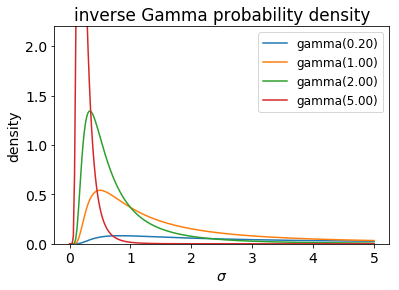

In [4]:
'''examples of inverse Gamma distribution'''
s = np.linspace(0.002, 5, 250)
for a in [0.2, 1.0, 2.0, 5.0]:
    plt.plot(s, stats.invgamma(a).pdf(s), label='gamma({:.2f})'.format(a))
plt.ylim(0.0, 2.2)
plt.title('inverse Gamma probability density')
plt.xlabel('$\sigma$')
plt.ylabel('density')
plt.legend(fontsize=12);

## Zutaten für Bayes

- Datenvektor $\{y_i\}$ (Länge $N$)
- Mittelwert $\mathbf{y}$ (Schätzer $\overline{y}$)
- Standardabweichung für $y$ (Störparameter; Schätzer $s$)
- robuste Schätzung (akzeptiert Ausreißer)
    - Student $t$ (statt Normalverteilung)
    - mit zusätzlichem Parameter *Freiheitsgrade* $\nu$
- $\Rightarrow$ Parameter $\mu, \sigma, \nu$

## Daraus Modell für PyStan

In [5]:
model1 = '''
data{
    int<lower=1> Ntotal;         # number of measurements
    real y[Ntotal];              # vector of data values
    real meanY;                  # estimator on prior from data
    real sdY;                    #   -"-
}
transformed data{
    real unifLo;             # min value for uniform sigma prior
    real unifHi;             # max value for -"-
    real normalSigma;        # width of normal prior for mu
    real expLambda;          # parameter for exponential prior on nu
    unifLo = sdY / 1000;     # down to exceptionally small
    unifHi = sdY * 1000;     # up to exceptionally large 
    normalSigma = sdY * 100; # really broad distributed
    expLambda = 1/29.0;      # 30 is like Normal: allow deviation towards both
}
parameters{
    real<lower=0> numinusone;# nuisance degree of freedom of t-distribution
    real mu;          # our parameter of interest: expectation value of data
    real<lower=0> sigma;     # nuisance parameter width 
} 
transformed parameters{
    real<lower=0> nu;   # exponential distribution needs nu transformed:
    nu = numinusone + 1;# nu must be >=1, numinusone will be drawn from exponential (>=0)
}
model{
    sigma ~ uniform(unifLo, unifHi);    # width of y-distribution
    mu ~ normal(meanY, normalSigma);    # center of y-distribution
    numinusone ~ exponential(expLambda);# shape of y-distribution, transformed df for...
    y ~ student_t(nu, mu, sigma);       # student-t(df=nu, loc=mu, scale=sigma)
}
'''

In [6]:
'''the data'''
# see : https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/tree/master/2e
# load data set
rawdata = pd.read_csv('KruschkePrograms/TwoGroupIQ.csv', sep=',', engine='python')
rawdata.columns                       # what variables do we have?

Index(['Score', 'Group'], dtype='object')

In [7]:
# select only data of treatment group
dataIQ = rawdata['Score'][rawdata['Group']=='Smart Drug'].values
dataIQ  # what data values do we have?

array([102, 107,  92, 101, 110,  68, 119, 106,  99, 103,  90,  93,  79,
        89, 137, 119, 126, 110,  71, 114, 100,  95,  91,  99,  97, 106,
       106, 129, 115, 124, 137,  73,  69,  95, 102, 116, 111, 134, 102,
       110, 139, 112, 122,  84, 129, 112, 127, 106, 113, 109, 208, 114,
       107,  50, 169, 133,  50,  97, 139,  72, 100, 144, 112])

In [8]:
data1 = { # wrap all data into a dictionary for PyStan
    'y':       dataIQ,
    'Ntotal':  len(dataIQ),
    'meanY':   dataIQ.mean(),
    'sdY':     dataIQ.std()
}

## MCMC mit PyStan

In [9]:
'''ready to fit'''
# initialize model
stanmdl1 = pystan.StanModel(model_code=model1, model_name='IQ_smartdrug')
# perform NUTS MCMC
fit1 = stanmdl1.sampling(data=data1, iter=7000, warmup=2000, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL IQ_smartdrug_cbf83e5e2bf06835881860ed3f7d4185 NOW.
/home/data/anacondaCent/envs/statistikII/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


    .../pystan/misc.py:399: FutureWarning: 
    Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. 
    In future, it will be treated as `np.float64 == np.dtype(float).type`.

betroffene Datei ist psytan/misc.py, dort gefixt im Februar 2018.
Jedoch:

    Latest release    v2.17.1.0   released on 16 Jan 2018

In [10]:
print(fit1)

Inference for Stan model: IQ_smartdrug_cbf83e5e2bf06835881860ed3f7d4185.
4 chains, each with iter=7000; warmup=2000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
numinusone   8.89    0.14  13.39   0.86   2.56    4.6   9.19  47.04   8667    1.0
mu         107.19    0.03   2.85 101.59  105.3 107.19 109.07 112.86  12145    1.0
sigma       19.83    0.04    3.5  13.29  17.36  19.74  22.21  26.82   8657    1.0
nu           9.89    0.14  13.39   1.86   3.56    5.6  10.19  48.04   8667    1.0
lp__       -249.9    0.01   1.27 -253.2 -250.5 -249.6 -248.9 -248.4   7646    1.0

Samples were drawn using NUTS at Mon Jul  9 08:11:39 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Ergebnis MCMC Posteriors

In [11]:
mu1 = fit1.extract()['mu']
nu1 = fit1.extract()['nu']
sigma1 = fit1.extract()['sigma']

## Posterior $\mu$

In [13]:
import AngStII_Bayes as bayes

hdi1 = bayes.HDIofMCMC(mu1)
print('95%-HDI:', hdi1)

def plothdiofchain(chain, col, maxx):
    '''little helper to directly plot the hdi,
    usually into an open graph with histogram'''
    hdi = bayes.HDIofMCMC(chain)
    plt.plot(2*[hdi[0]], [0, maxx], col+'--',
             label='95% HDI=[{:.1f}, {:.1f}]'.format(hdi[0], hdi[1]))
    plt.plot(2*[hdi[1]], [0, maxx], col+'--')

95%-HDI: (101.45657199760088, 112.69754507251997)


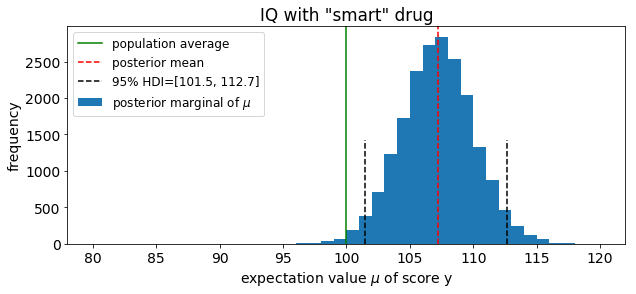

In [14]:
'''posterior of mu, the expectation value of IQ score with "smart" drug'''
f = plt.figure(figsize=(10, 4))
h = plt.hist(mu1, bins=np.linspace(80, 120, 41), label='posterior marginal of $\mu$')
# reference 100
plt.axvline(100,        c='g', ls='-',  label='population average')
# posterior point estimate
plt.axvline(mu1.mean(), c='r', ls='--', label='posterior mean')
plothdiofchain(mu1, 'k', h[0].max()/2) # 95%-HDI of posterior chain 
plt.title('IQ with "smart" drug')       
plt.xlabel('expectation value $\\mu$ of score y')
plt.ylabel('frequency')
plt.legend(loc='upper left', fontsize=12);

## Posterior $\nu$

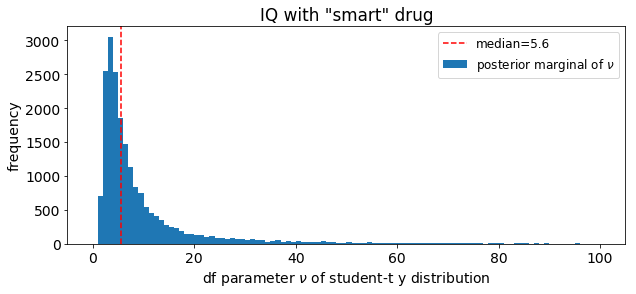

In [15]:
'''posterior of nu, the shape parameter of student-t
IQ-distribution with "smart" drug'''
# finding MAP would need to fit a known distribution
# median is robust against tranformation
numed = np.median(nu1)
f = plt.figure(figsize=(10, 4))
h = plt.hist(nu1, bins=np.linspace(0, 100, 101),
             label='posterior marginal of $\\nu$')
plt.axvline(numed, c='r', ls='--', label='median={:.1f}'.format(numed))
plt.title('IQ with "smart" drug')
plt.xlabel('df parameter $\\nu$ of student-t y distribution')
plt.ylabel('frequency')
plt.legend(loc='upper right', fontsize=12);

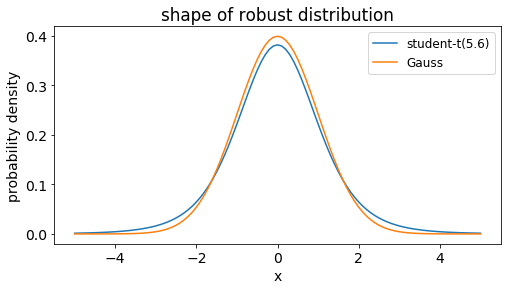

In [16]:
'''just for comparison t(5.6) vs. Gaussian'''
f = plt.figure(figsize=(8, 4))
xgrid = np.linspace(-5, 5, 101) # 5-sigma range
plt.plot(xgrid, stats.t(numed).pdf(xgrid),
         label='student-t({:.1f})'.format(numed))
plt.plot(xgrid, stats.norm(0, 1).pdf(xgrid), label='Gauss')
plt.title('shape of robust distribution')
plt.xlabel('x')
plt.ylabel('probability density')
plt.legend(loc='upper right', fontsize=12);

## Posterior $\sigma$

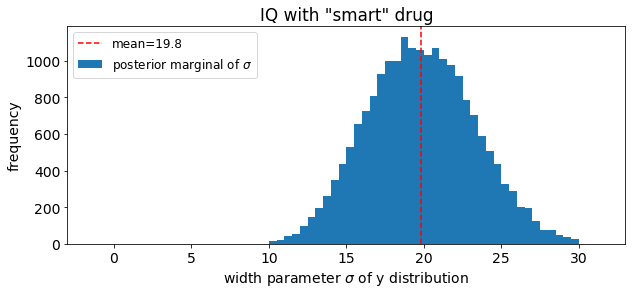

In [17]:
'''posterior of sigma, the width parameter of
IQ-distribution with "smart" drug'''
f = plt.figure(figsize=(10, 4))
h = plt.hist(sigma1, bins=np.linspace(10, 30, 41),
             label='posterior marginal of $\\sigma$')
plt.axvline(sigma1.mean(), c='r', ls='--',
            label='mean={:.1f}'.format(sigma1.mean()))
plt.title('IQ with "smart" drug')
plt.xlabel('width parameter $\sigma$ of y distribution')
plt.ylabel('frequency')
plt.xlim((-3, 33))
plt.legend(loc='upper left', fontsize=12);

## Posterior Verteilung $\;p(\theta|D)$

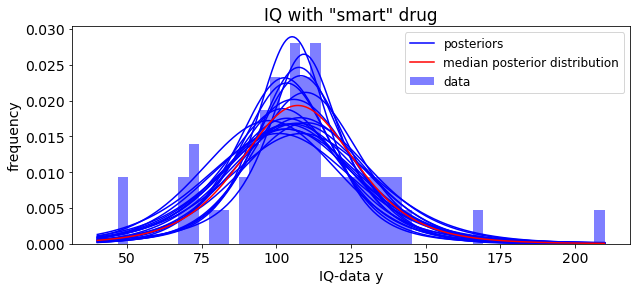

In [18]:
'''show data with median distribution and collection of posterior distributions'''
f = plt.figure(figsize=(10, 4))
# selection of 20 valid posteriors from total of 20000 as examples
# random selection of posterior(s)
indices = np.random.choice(a=len(mu1), size=20, replace=False, p=None)
plt.hist(data1['y'], bins=np.linspace(40, 210, 50+1), label='data',
         color='b', alpha=.5, density=True)
xx = np.linspace(40, 210, 251)
for i, ix in enumerate(indices):
    if i==0:           # only one label for legend
        plt.plot(xx, stats.t.pdf(x=xx, df=nu1[ix],
                                 loc=mu1[ix], scale=sigma1[ix]),
                 'b', label='posteriors')
    else:
        plt.plot(xx, stats.t.pdf(x=xx, df=nu1[ix], loc=mu1[ix],
                                 scale=sigma1[ix]), 'b')
        
# the median distribution; mu and sigma correspond to mean/max;
# nu distribution is skewed
pars = np.median([nu1, mu1, sigma1], axis=1)
plt.plot(xx, stats.t.pdf(x=xx, df=pars[0], loc=pars[1], scale=pars[2]), 'r', 
         label='median posterior distribution')
plt.title('IQ with "smart" drug')
plt.xlabel('IQ-data y')
plt.ylabel('frequency')
plt.legend(loc='upper right', fontsize=12);

## Ergebnis 1: Eine Verteilung

- Posterior beschreibt passende Verteilungen an Daten
    - Modell ist angemessen
- Ausreißer werden durch t-Verteilung beschrieben
    - Abweichung von Normalverteilung mit Freiheitsgrade-Parameter $\nu=5.6$ (Median)
- Erwartungswert der Verteilung "*smart drug*" über dem Durchschnitt "ohne"
    - Punktschätzer für $\mu = 107$
    - Breite der Verteilung von $\mu$: Mittelwertsfehler innerhalb 95%-HDI $[101.7,\, 112.6]$
    - Breite der Verteilung der Daten: Parameter $\sigma = 20$ mit $[t_{0.025}\!=\!58,\, t_{0.975}\!=\!157]$

# Fragen?

# Beispiel 2: Zwei IQ-Kategorien

In [20]:
'''prepare the group variable as categorial identifier'''
rawdata['category'] = 1 # initialize new variable with 1
# set smart_drug=2, keep placebo=1
rawdata.loc[rawdata['Group']=='Smart Drug', 'category'] = 2

In [21]:
data2 = {
    'category':  rawdata['category'].values, 
    'y':         rawdata['Score'].values,
    'Ntotal':    len(rawdata),
    'meanY':     rawdata['Score'].values.mean(),
    'sdY':       rawdata['Score'].values.std()
}

In [22]:
data2

{'category': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'y': array([102, 107,  92, 101, 110,  68, 119, 106,  99, 103,  90,  93,  79,
         89, 137, 119, 126, 110,  71, 114, 100,  95,  91,  99,  97, 106,
        106, 129, 115, 124, 137,  73,  69,  95, 102, 116, 111, 134, 102,
        110, 139, 112, 122,  84, 129, 112, 127, 106, 113, 109, 208, 114,
        107,  50, 169, 133,  50,  97, 139,  72, 100, 144, 112, 109,  98,
        106, 101, 100, 111, 117, 104, 106,  89,  84,  88,  94,  78, 108,
        102,  95,  99,  90, 116,  97, 107, 102,  91,  94,  95,  86, 108,
        115, 108,  88, 102, 102, 120, 112, 100, 105, 105,  88,

### Stan model string

    data{
        int<lower=1> Ntotal;         # number of measurements
        real y[Ntotal];              # vector of data values
        int  group[Ntotal];          # categorization identifier of data [1 or 2]
        real meanY;                  # estimator on prior
        real sdY;                    #   -"-
    }

    parameters{
        real<lower=0> numinusone;    # nuisance degree of freedom of t-distribution (same)
        real mu[2];                  # vector of parameters of interest in two categories
        real<lower=0> sigma[2];      # nuisance parameters width 
    } 

    model{
        sigma ~ uniform(unifLo, unifHi);       # width of y-distributions (vectorized)
        mu ~ normal(meanY, normalSigma);       # center of y-distributions (vectorized)
        numinusone ~ exponential(expLambda);   # shape of y-distribution (same) transformed df for...
        for( i in 1:Ntotal ) {                 # student-t(df=nu, loc=mu, scale=sigma)
            y[i] ~ student_t(nu, mu[group[i]], sigma[group[i]]);   # select according to indexing group
        }
    }

In [23]:
'''This is the complete model string for a (normal like) t-distribution of IQ data y'''
model2 = '''
data{
    int<lower=1> Ntotal;         # number of measurements
    real y[Ntotal];              # vector of data values
    int  category[Ntotal];       # categorization identifier of data [1 or 2]
    real meanY;                  # estimator on prior
    real sdY;                    #   -"-
}
transformed data{
    real unifLo;                 # min value for uniform sigma prior
    real unifHi;                 # max value for -"-
    real normalSigma;            # width of normal prior for mu
    real expLambda;              # parameter for exponential prior on nu
    unifLo = sdY / 1000;         # down to exceptionally small
    unifHi = sdY * 1000;         # up to exceptionally large 
    normalSigma = sdY * 100;     # really broad distributed
    expLambda = 1/29.0;          # 30 is like Normal: allow deviation towards both
}
parameters{
    real<lower=0> numinusone;# nuisance degree of freedom of t-distribution (same)
    real mu[2];              # vector of parameters of interest in two categories
    real<lower=0> sigma[2];  # nuisance parameters width 
} 
transformed parameters{
    real<lower=0> nu;   # exponential distribution needs nu transformed:
    nu = numinusone + 1;# nu must be >=1, numinusone will be drawn from exponential (>=0)
}
model{
    sigma ~ uniform(unifLo, unifHi);       # width of y-distributions (vectorized)
    mu ~ normal(meanY, normalSigma);       # center of y-distributions (vectorized)
    numinusone ~ exponential(expLambda);# shape of y-distribution (same) transformed df for...
    for( i in 1:Ntotal ) {                 # student-t(df=nu, loc=mu, scale=sigma)
        y[i] ~ student_t(nu, mu[category[i]], sigma[category[i]]);  # select accordingly
    }
}
'''

In [24]:
'''ready to fit'''
stanmdl2 = pystan.StanModel(model_code=model2, model_name='IQ_compare')
fit2 = stanmdl2.sampling(data=data2, iter=7000, warmup=2000, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL IQ_compare_4f8ac0852cbf495b4e427d8fec1d4b3d NOW.


Berechnung dauert nun 4x ~3 Sekunden...

    Iteration: 6900 / 7000 [ 98%]  (Sampling)
    Iteration: 7000 / 7000 [100%]  (Sampling)

     Elapsed Time: 1.11 seconds (Warm-up)
                   1.73 seconds (Sampling)
                   2.84 seconds (Total)


In [25]:
'''show result summary'''
print(fit2)

Inference for Stan model: IQ_compare_4f8ac0852cbf495b4e427d8fec1d4b3d.
4 chains, each with iter=7000; warmup=2000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
numinusone   2.92    0.02   1.88   0.95   1.81   2.52   3.51   7.09  12503    1.0
mu[0]       99.25    0.01    1.8  95.68  98.07  99.26 100.44  102.8  20000    1.0
mu[1]      107.14    0.02   2.69 101.87 105.33 107.15 108.96 112.35  20000    1.0
sigma[0]    11.35    0.01   1.74   8.35  10.12  11.22  12.44  15.09  16481    1.0
sigma[1]    17.95    0.02   2.72  13.08  16.05  17.79  19.69  23.67  16784    1.0
nu           3.92    0.02   1.88   1.95   2.81   3.52   4.51   8.09  12503    1.0
lp__       -451.3    0.02   1.62 -455.4 -452.1 -451.0 -450.1 -449.2   9113    1.0

Samples were drawn using NUTS at Mon Jul  9 08:14:58 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potenti

In [26]:
'''get the posterior chains for the two different categories'''
mu1 = fit2.extract()['mu'][:,0]     # chain for mu of category "placebo"
mu2 = fit2.extract()['mu'][:,1]     # chain for mu of category "smart drug"

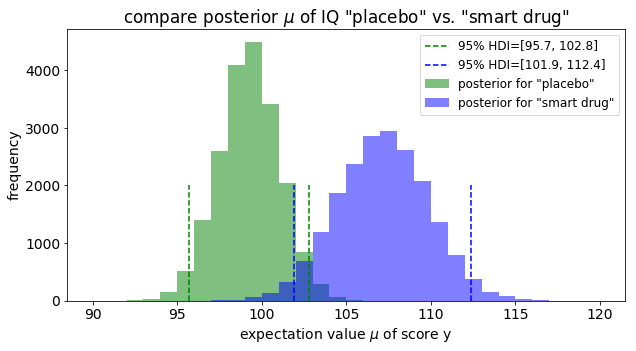

In [27]:
'''compare mu of both categories "placebo" and "smart drug"'''
plt.figure(figsize=(10, 5))
bins = np.linspace(90, 120, 31)
plt.hist(mu1, bins=bins, label='posterior for "placebo"', color='g', alpha=.5)
plothdiofchain(mu1, 'g', 2000)
plt.hist(mu2, bins=bins, label='posterior for "smart drug"', color='b', alpha=.5)
plothdiofchain(mu2, 'b', 2000)
plt.title('compare posterior $\\mu$ of IQ "placebo" vs. "smart drug"')
plt.xlabel('expectation value $\\mu$ of score y')
plt.ylabel('frequency')
plt.legend(loc='upper right', fontsize=12);

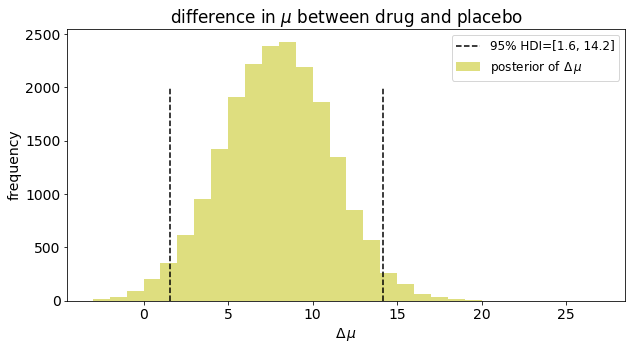

In [28]:
'''compare mu of both categories "placebo" and "smart drug"'''
dmu = mu2 - mu1                          # we expect a positive difference
plt.figure(figsize=(10,5))
plt.hist(dmu, bins=np.linspace(-3, 30-3, 30+1), color='y', alpha=.5,
         label="posterior of $\\Delta\,\\mu$")
plothdiofchain(dmu, 'k', 2000)
plt.legend(loc='upper right', fontsize=12)
plt.title('difference in $\\mu$ between drug and placebo')
plt.xlabel('$\Delta\,\mu$')
plt.ylabel('frequency');

## Ergebnis Datenverteilung in zwei Kategorien

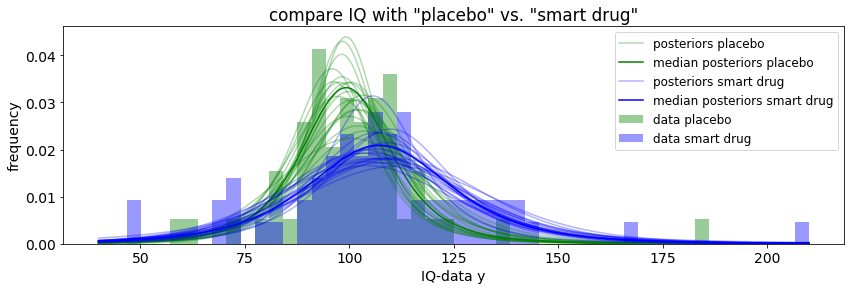

In [29]:
'''show data with median distribution and collection of posterior distributions'''
f = plt.figure(figsize=(14, 4))
mu1 = fit2.extract()['mu'][:,0]      # chain for mu of category "placebo"
mu2 = fit2.extract()['mu'][:,1]      #                 category "smart drug"
sigma1 = fit2.extract()['sigma'][:,0]# chain for sigma of category "placebo"
sigma2 = fit2.extract()['sigma'][:,1]#                    category "smart drug"
nu = fit2.extract()['nu']       # (one) chain for nu valid for both categories

# selection of 2x20 valid posteriors from total of 20000 as examples
# random selection of placebo posterior
indices1 = np.random.choice(a=len(mu1), size=20, replace=False, p=None)
# random selection of drug posterior
indices2 = np.random.choice(a=len(mu2), size=20, replace=False, p=None)
plt.hist(rawdata[rawdata['category']==1]['Score'],
         bins=np.linspace(40, 210, 50+1), 
         label='data placebo', color='g', alpha=.4, density=True)
plt.hist(rawdata[rawdata['category']==2]['Score'],
         bins=np.linspace(40, 210, 50+1), 
         label='data smart drug', color='b', alpha=.4, density=True)

xx = np.linspace(40, 210, 251)
for i, ix in enumerate(indices1):
    if i==0:           # only one label for legend
        plt.plot(xx, stats.t.pdf(x=xx, df=nu[ix],
                                 loc=mu1[ix], scale=sigma1[ix]),
                 'g', alpha=.3, label='posteriors placebo')
    else:
        plt.plot(xx, stats.t.pdf(x=xx, df=nu[ix], loc=mu1[ix],
                                 scale=sigma1[ix]), 'g', alpha=.3)
plt.plot(xx, stats.t.pdf(x=xx, df=np.median(nu), loc=np.median(mu1),
                         scale=np.median(sigma1)),
         'g', label='median posteriors placebo')
for i, ix in enumerate(indices2):
    if i==0:           # only one label for legend
        plt.plot(xx, stats.t.pdf(x=xx, df=nu[ix], loc=mu2[ix],
                                 scale=sigma2[ix]),
                 'b', alpha=.3, label='posteriors smart drug')
    else:
        plt.plot(xx, stats.t.pdf(x=xx, df=nu[ix], loc=mu2[ix],
                                 scale=sigma2[ix]), 'b', alpha=.3)
plt.plot(xx, stats.t.pdf(x=xx, df=np.median(nu), loc=np.median(mu2),
                         scale=np.median(sigma2)),
         'b', label='median posteriors smart drug')
plt.title('compare IQ with "placebo" vs. "smart drug"')
plt.xlabel('IQ-data y')
plt.ylabel('frequency')
plt.legend(loc='upper right', fontsize=12);

## Ergebnis 2: Kategorien

#### Kategorien können mit einem Modell angepaßt werden

- Gruppierte Daten $y_{ji}$
- Indikator-Variable "*category*" mit Inhalt $j$
- Parametervektor $\boldsymbol\mu = [\mu_j]$

#### Posterior erlaubt Vergleich

- Posterior der Differenz beider Ketten
    - die Differenz  $\;\Delta\,\mu=\mu_{smart\;drug}-\mu_{Placebo}\;$  ist positiv und von Null verschieden
    - das 95%-HDI für $\Delta\,\mu$  liegt außerhalb einer *ROPE* von $0\pm 1$

# Fragen?

# Lineares Modell

Erweiterung der Kategorien auf beliebig viele: Abhängigkeit von einem (oder mehreren) unabbhängigen (Vorhersage-) Variablen $X$

#### Beispiel:

1. Intelligenztest: IQ-Messung
    - Verteilung
2. Intelligenztest: IQ-Vergleich zweier Bedingungen
    - zwei Verteilungen
    - zwei Kategorien "*placebo*" und "*smart drug*"
3. Intelligenztest: IQ in Abhängigkeit von der Konzentration eines Dopings
    - kontinuierlicher Vorhersage-Parameter
    - Verteilung für IQ ändert sich kausal 

#### Wahrscheinlichkeitsverteilung der abhängigen Zufallsvariablen $Y$

Ursache: Streuung, Rauschen, Meßfehler, ... = Zufall

$$\begin{aligned} \mathcal{E}(Y_i) &= \mu_i \\
Y_i\; &\sim \mathcal{N}(\mu_i, \sigma^2)\end{aligned}$$
mit der Linearen Abhängigkeit von unabhängigen Variablen $X_j$
$$ \mu_i = \mathbf{x}_i^T\boldsymbol\beta = \sum_{j=1}^{N_j}\beta_j x_{ji}$$
mit der Generalisierten Linearen Abhängigkeit
$$ g(\mu_i) = \mathbf{x}_i^T\boldsymbol\beta$$

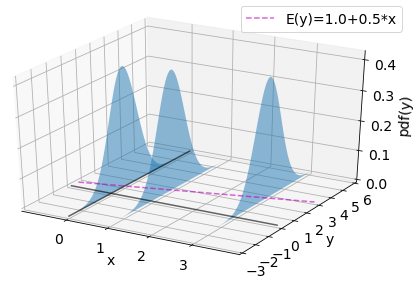

## Mathematisches Modell: Designmatrix und Parametervektor

**Designmatrix** mit $k$ unabhängigen Variablen $X_j$ in Spalten der Länge $n$ (Anzahl der Messwerte)

$$ \mathbf{X} = \begin{bmatrix} 
1      & X_{11} & X_{12} & \dots & X_{1k} \\
1      & X_{21} & X_{22} & \dots & X_{2k} \\
\vdots & \;     & \ddots & \;    & \vdots \\
1      & X_{n1} & X_{n2} & \dots & X_{nk}      \end{bmatrix}$$
**Parametervektor**
$$\boldsymbol\beta = \begin{bmatrix}\beta_0\\ \beta_1\\ \vdots \\\beta_k \end{bmatrix}$$

#### Generalisiertes Lineares Modell

$$g\bigl(\mathcal{E}(\mathbf{Y})\bigr) = g\bigl(\boldsymbol\mu\bigr) = \mathbf{X}\boldsymbol\beta$$
$$Y_i \sim f(y_i;\boldsymbol\theta_i) \quad\text{z.B.}\quad \mathcal{N}(\mu_i, \sigma_i^2)$$

## Varianten unabhängiger Variablen

- Nominal, eine Kategorie mit Faktor $\beta_0$
- Nominal, mehrere Kategorien mit Faktoren $\beta_i\quad i\in\mathbb{N}^{+}\;$ und Indikatorvariablen in Designmatrix
- Eine metrische Variable $\beta_0 + \beta_1 x$
- Mehrere metrische Variablen $\beta_0 + \sum_j \beta_j x_j$
- mit Interaktion $\beta_0 + \sum_j \beta_j x_j + \sum_{jk} \beta_{jk} x_j x_k [+...]$
- Ordinale Variable(n) ($\rightarrow$ nominal; aber Reihenfolge spielt Rolle)

## Beispiel für Link-Funktion $g$: 

$$g(\eta) = \mathrm{logistic}(\eta) = \frac{1}{1+e^{-\eta}}$$
ausgedrückt durch unabhängige Variable $X$
$$g(x;\beta_0,\beta_1) = \frac{1}{1+e^{-(\beta_0+\beta_1 x)}}$$
umparametrisiert mittels *gain* $\;\gamma\;$ und *threshold* $\;\theta\;$:
$$g(x;\gamma,\theta) = \frac{1}{1+e^{-\gamma(x-\theta)}}$$

# Beispiel 3: Lineares Modell *Säugetier-Gehirngewicht*

Zum Vergleich mit frequentistischer Statistik, siehe GLM

In [30]:
'''import the dataset from csv file (tab-separated) into a Pandas dataframe object:'''
animals = pd.read_csv('data/animals.txt', sep='\t')  # tab-separated

'''rescale weight because of spread: create new variable from linear data'''
# new variable, converted from original data
animals['log_BodyWt'] = np.log10(animals['BodyWt'])
# new variable, converted from original data
animals['log_BrainWt'] = np.log10(animals['BrainWt'])
# focus on list of relevant data
animalsdata = animals[['log_BodyWt', 'log_BrainWt', 'Species']]
animalsdata = animalsdata.dropna(axis=0) # drop lines with invalid data

In [31]:
import statsmodels.formula.api as smf

'''fit linear Gaussian (default) model with Patsy formula'''
wfit = smf.glm(formula='log_BrainWt ~ log_BodyWt', data=animalsdata).fit()

In [32]:
print(wfit.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:            log_BrainWt   No. Observations:                    62
Model:                            GLM   Df Residuals:                        60
Model Family:                Gaussian   Df Model:                             1
Link Function:               identity   Scale:              0.09091935824611976
Method:                          IRLS   Log-Likelihood:                 -12.626
Date:                Mon, 09 Jul 2018   Deviance:                        5.4552
Time:                        08:16:14   Pearson chi2:                      5.46
No. Iterations:                     2                                          
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9271      0.042     22.227      0.000       0.845       1.009
log_BodyWt     0.7517      0.028     26.409

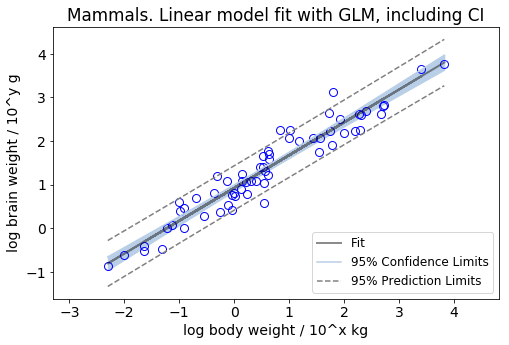

In [33]:
# get data
x = np.asarray(animalsdata['log_BodyWt'])  # extract independent variable
y = np.asarray(animalsdata['log_BrainWt']) # extract dependent variable
y_hat = np.asarray(wfit.fittedvalues)      # estimated linear result
x_bar = x.mean()

# Statistics
# used for CI and PI bands according to residua's degree-of-freedom
t = stats.t.ppf(0.95, wfit.df_resid)

# Estimates of Error in Data/Model           
# standard deviation of the error
s_err = np.sqrt(np.sum(wfit.resid_response**2)/(wfit.df_resid))

fig = plt.figure(figsize=(8,5))
# show data
plt.plot(x, y,'o', color='#b9cfe7', markersize=8,
         markeredgewidth=1,markeredgecolor='b',markerfacecolor='None')
# show fit
plt.plot(x, y_hat,'-', color='0.1', linewidth=2, alpha=0.5, label='Fit')  

x2 = np.linspace(np.min(x), np.max(x), 100)
# IF SLEEP: reverse due to decrease
y2 = np.linspace(np.min(y_hat), np.max(y_hat), 100)

# confidence interval
CI = t*s_err*np.sqrt(1/len(x) +(x2-x_bar)**2/np.sum((x-x_bar)**2))
plt.fill_between(x2, y2+CI, y2-CI, color='#b9cfe7', edgecolor='')
# Minor hack for labeling CI fill_between()
plt.plot(x2, y2+CI, '-', color='#b9cfe7', label='95% Confidence Limits')

# Prediction Interval
PI = t*s_err*np.sqrt(1+1/len(x)+(x2-x_bar)**2/np.sum((x-x_bar)**2))   
plt.fill_between(x2, y2+PI, y2-PI, color='None', linestyle='--')
plt.plot(x2, y2-PI, '--', color='0.5', label='95% Prediction Limits')
plt.plot(x2, y2+PI, '--', color='0.5')

# Labels
plt.title('Mammals. Linear model fit with GLM, including CI')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
plt.legend(loc='lower right', fontsize=12)
plt.xlim(np.min(x)-1,np.max(x)+1);

# Wie mit Bayes-Statistik?

$$p(\beta_0, \beta_1, \sigma, \nu|D) = \frac
{p(D|\beta_0, \beta_1, \sigma, \nu)p(\beta_0, \beta_1, \sigma, \nu)}
{\int\int\int\int p(D|\beta_0, \beta_1, \sigma, \nu)p(\beta_0, \beta_1, \sigma, \nu) \,\mathrm{d}\beta_0\,\mathrm{d}\beta_1\,\mathrm{d}\sigma\,\mathrm{d}\nu}$$

# Wie mit MCMC aus PyStan?

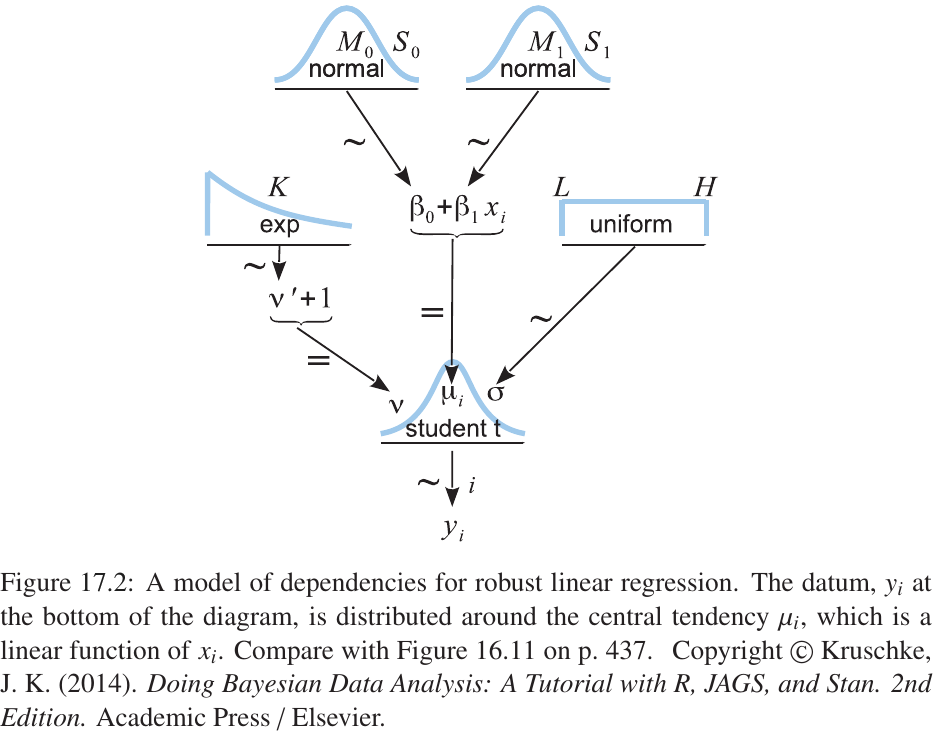

#### Parameter von Interesse: 

- Parmetervektor $\boldsymbol{\beta}$
    - besteht ein linearer Zusammenhang zwischen $X$ und $Y$? $\;\Rightarrow$ *gain* $\beta_1 \neq 0$
    - ist der lineare Zusammenhang proportional? $\;\Rightarrow$ *intercept* $\beta_0 = 0$
- Streuung der Daten $\sigma$
- Abweichung von Normalverteilung (robust gegen Ausreißer)
- üblicherweise **nicht** $\mu_i$ (wird von $\boldsymbol{\beta}$ und $X$ vorhergesagt)
- Vorgaben für konstante Prior-Parameter $M_i$, $S_i$, $K$, $L$, $H$.

In [34]:
modelL = '''
data{
    int<lower=1> Ntotal;   
    real x[Ntotal];
    real y[Ntotal];
    real meanY;
    real sdY;
    real meanX;
    real sdX;
}
transformed data{
    real unifLo;                # uniform prior for sigma low
    real unifHi;                #                         high
    real expLambda;             # exponential prior for nu-1 of nu=df-of-t
    real<lower=0> beta0sigma;   # width of normal prior for beta0 intercept 
    real<lower=0> beta1sigma;   # width of normal prior for beta1 gain 
    unifLo = sdY/1000;          # exceptionally low, but positive
    unifHi = sdY*1000;          # exceptionally high
    expLambda = 1/29.0;         # 30 is near Normal, allow all
    beta1sigma = 10*fabs( sdY/sdX );        # worst case gain if correlated 1:1
    beta0sigma = 10*fabs( meanX*sdY/sdX );  # worst case intercept -"-
}
parameters{
    real beta0;                 # intercept of linear regression
    real beta1;                 # gain of linear regression
    real<lower=0> numinusone;   # nu-1 is for nu = df of t
    real<lower=0> sigma;        # sigma of student-t for y 
}
transformed parameters{
    real <lower=0> nu;          # df of t; already restricted by numinusone
    nu = numinusone+1;          # fixed relation
}
model{
    sigma ~ uniform( unifLo, unifHi );    # nuisance parameter width of data
    numinusone ~ exponential( expLambda );# nuisance parameter (un-) normal shape of t 
    beta0 ~ normal( 0, beta0sigma );      # intercept in all directions, width above
    beta1 ~ normal( 0, beta1sigma );      # gain      -"-
    for( i in 1:Ntotal ) {                # data (no vectorization)
        # t(df, loc, scale) is a robust Normal
        y[i] ~ student_t( nu, beta0+beta1*x[i], sigma);
    }
}
'''

#### model string (lower part)

    parameters{
        real beta0;                 # intercept of linear regression
        real beta1;                 # gain of linear regression
        real<lower=0> numinusone;   # nu-1 is for nu = df of t
        real<lower=0> sigma;        # sigma of student-t for y 
    }
    transformed parameters{
        real <lower=0> nu;          # df of t; already restricted by numinusone
        nu = numinusone+1;          # fixed relation
    }
    model{
        sigma ~ uniform( unifLo, unifHi );       # nuisance parameter width of data
        numinusone ~ exponential( expLambda );   # nuisance parameter (un-) normal shape of t 
        beta0 ~ normal( 0, beta0sigma );         # intercept in all directions, width above
        beta1 ~ normal( 0, beta1sigma );         # gain      -"-
        for( i in 1:Ntotal ) {                   # data (no vectorization)
            y[i] ~ student_t( nu, beta0+beta1*x[i], sigma);  # t(df, loc, scale) is a robust Normal
        }
    }

#### model string (upper part)

    data{
        int<lower=1> Ntotal;   
        real x[Ntotal];
        real y[Ntotal];
        real meanY;
        real sdY;
        real meanX;
        real sdX;
    }
    transformed data{
        real unifLo;                # uniform prior for sigma low
        real unifHi;                #                         high
        real expLambda;             # exponential prior for nu-1 of nu=df-of-t
        real<lower=0> beta0sigma;   # width of normal prior for beta0 intercept 
        real<lower=0> beta1sigma;   # width of normal prior for beta1 gain 
        unifLo = sdY/1000;          # exceptionally low, but positive
        unifHi = sdY*1000;          # exceptionally high
        expLambda = 1/29.0;         # 30 is near Normal, allow all
        beta1sigma = 10*fabs( sdY/sdX );        # worst case gain if correlated 1:1
        beta0sigma = 10*fabs( meanX*sdY/sdX );  # worst case intercept -"-
    }

In [35]:
'''make data dictionary for PyStan'''
x = animalsdata['log_BodyWt'].values
y = animalsdata['log_BrainWt'].values
dataL = {
    'Ntotal': len(x),       # number of data; must be same for y   
    'x':      x,            # log(body weight)
    'y':      y,            # log(brain weight)
    'meanY':  y.mean(),
    'sdY':    y.std(),
    'meanX':  x.mean(),
    'sdX':    x.std()
}

In [36]:
'''ready to fit'''
stanmdlL = pystan.StanModel(model_code=modelL, model_name='AnimalsWeights')
fitL = stanmdlL.sampling(data=dataL, iter=7000, warmup=2500, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL AnimalsWeights_0bdde7421722123281998516968da70c NOW.


Während `warmup`:

    Iteration:    1 / 7000 [  0%]  (Warmup)
    Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
    Exception: student_t_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 39)

    If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices,
    then the sampler is fine, but if this warning occurs often then your model may be either severely ill-conditioned
    or misspecified.

In [37]:
print(fitL)

Inference for Stan model: AnimalsWeights_0bdde7421722123281998516968da70c.
4 chains, each with iter=7000; warmup=2500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0        0.92  3.3e-4   0.04   0.84   0.89   0.92   0.95   1.01  15727    1.0
beta1        0.75  2.2e-4   0.03   0.69   0.73   0.75   0.77   0.81  16083    1.0
numinusone  32.27    0.22  28.52   3.64  12.12  23.57  43.29 108.51  16370    1.0
sigma        0.29  2.8e-4   0.03   0.23   0.27   0.29   0.31   0.36  13588    1.0
nu          33.27    0.22  28.52   4.64  13.12  24.57  44.29 109.51  16370    1.0
lp__        22.09    0.02    1.4  18.57  21.41  22.41  23.12  23.83   8435    1.0

Samples were drawn using NUTS at Mon Jul  9 08:17:20 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [38]:
'''Posterior of Parameter vector beta and its HDI'''
import AngStII_Bayes as bayes

postbeta0 = fitL.extract()['beta0']        # chain for beta0: intercept
postbeta1 = fitL.extract()['beta1']        #           beta1: gain
hdi0 = bayes.HDIofMCMC(postbeta0)
print('95%-HDI of intercept beta_0: [{:6.3f}, {:6.3f}]'.format(hdi0[0], hdi0[1]))
hdi1 = bayes.HDIofMCMC(postbeta1)
print('95%-HDI of gain      beta_1: [{:6.3f}, {:6.3f}]'.format(hdi1[0], hdi1[1]))

95%-HDI of intercept beta_0: [ 0.844,  1.010]
95%-HDI of gain      beta_1: [ 0.698,  0.809]


## Ergebnis und Vergleich mit GLM: Parametervektor $\boldsymbol\beta$ 

#### Bayes-Posterior mittels PyStan

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
    beta0        0.92  3.4e-4   0.04   0.84   0.89   0.92   0.95   1.01  15849    1.0
    beta1        0.75  2.2e-4   0.03   0.69   0.73   0.75   0.77   0.80  16119    1.0

    95%-HDI of intercept beta_0: [ 0.842,  1.008]
    95%-HDI of gain      beta_1: [ 0.693,  0.804]

#### GLM Fit-Ergebnis für Parameter

                   coef  std err         z    P>|z|     [0.025   0.975]
    -------------------------------------------------------------------
    Intercept    0.9271    0.042    22.227    0.000      0.845   1.009
    log_BodyWt   0.7517    0.028    26.409    0.000      0.696   0.807


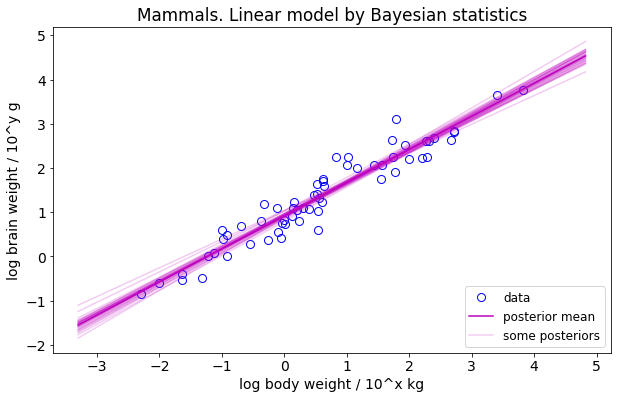

In [39]:
'''graphical result - parameter vector beta'''
f = plt.figure(figsize=(10, 6))
# show data
plt.plot(x, y,'o', color='#b9cfe7', markersize=8,
         markeredgewidth=1,markeredgecolor='b',
         markerfacecolor='None', label='data')

# get chains
xx = np.asarray([x.min()-1, x.max()+1])    # list of corners for straight line
meanb0 = postbeta0.mean()
meanb1 = postbeta1.mean()
plt.plot(xx, meanb0 + meanb1*xx, 'm-', label='posterior mean')

# selection of posteriors
# random selection of beta[]
indices = np.random.choice(a=len(postbeta0), size=30, replace=False, p=None)
for i, idx in enumerate(indices):
    b0, b1 = (postbeta0[idx], postbeta1[idx])
    if i==0:           # only one label for legend
        plt.plot(xx, b0 + b1*xx, 'm', alpha=.2, label='some posteriors')
    else:
        plt.plot(xx, b0 + b1*xx, 'm', alpha=.2)


# Labels
plt.title('Mammals. Linear model by Bayesian statistics')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
plt.legend(loc='lower right', fontsize=12);

## Ergebnis Störparameter

#### Abweichung von der Normalverteilung

Mittelwert von $\nu = 33.47$ mit Standardabweichung $s_{\nu} = 28.54$

$\Rightarrow$ die Abweichung von der Normalverteilung spielt keine Rolle und kann vernachlässigt werden.

#### Streuung

Mittelwert von $\sigma = 0.29$ mit Standardabweichung $s_{\sigma} = 0.03$

$\Rightarrow$ die Daten (Gehirngewicht) streuen um den linear vorhergesagten Erwartungswert ($\widehat{=}$ Faktor 2).

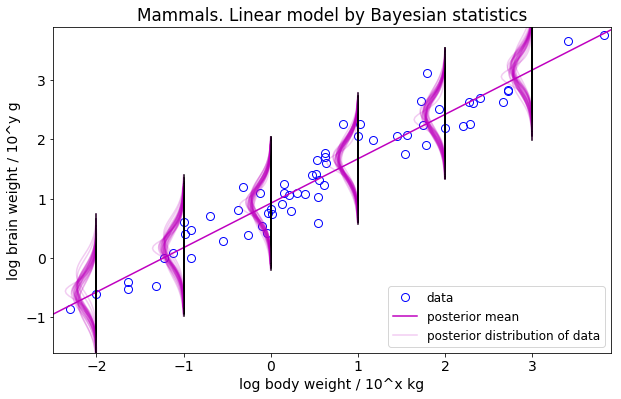

In [40]:
'''graphical result - data distribution'''
f = plt.figure(figsize=(10, 6))
# show data and mean distribution
plt.plot(x, y,'o', color='#b9cfe7', markersize=8,
         markeredgewidth=1,markeredgecolor='b',
         markerfacecolor='None', label='data')
plt.plot(xx, meanb0 + meanb1*xx, 'm-', label='posterior mean')

# get chains
postbeta0 = fitL.extract()['beta0']        # chain for beta0: intercept
postbeta1 = fitL.extract()['beta1']        #           beta1: gain
postnu    = fitL.extract()['nu']           #           nu: df in t
postsigma = fitL.extract()['sigma']        #           sigma: std of data

# 5x30 distributions out of posteriors
xpois = np.arange(-2, 4) # list of body weights "of interest" 10g up to 1t
for j, xpoi in enumerate(xpois):
    for i, idx in enumerate(indices):
        b0, b1, nu, sigma = (postbeta0[idx], postbeta1[idx],
                             postnu[idx], postsigma[idx])
        mu = b0 + b1*xpoi                       # center of line
        plt.plot(2*[xpoi], [mu-1, mu+1], 'k-')  # base line
        xi = np.linspace(mu-1, mu+1, 50+1) # grid for pdf x-axis; rotated to y
        # the posterior distribution
        ypdf = stats.t(df=nu, loc=mu, scale=sigma).pdf(xi)
        if i==0 and j==0:
            plt.plot(xpoi-.18*ypdf, xi, 'm-', alpha=.2,
                     label='posterior distribution of data')
        else:
            plt.plot(xpoi-.18*ypdf, xi, 'm-', alpha=.2)

plt.title('Mammals. Linear model by Bayesian statistics')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
plt.axis([-2.5, 3.9, -1.6, 3.9])
plt.legend(loc='lower right', fontsize=12);

## Ergebnis 3) Lineares Modell

- Datenverteilung wird sehr gut beschrieben

#### Vergleich mit  KQ/IRLS Linearem Modell

- Werte für Parametervektor stimmen überein
- Streuung der Parameter stimmt mit Konfidenzintervall überein
- Streuung der Daten stimmt mit Konfidenzintervall überein


# Beispiel 4: Lineares Modell mit Kategorien



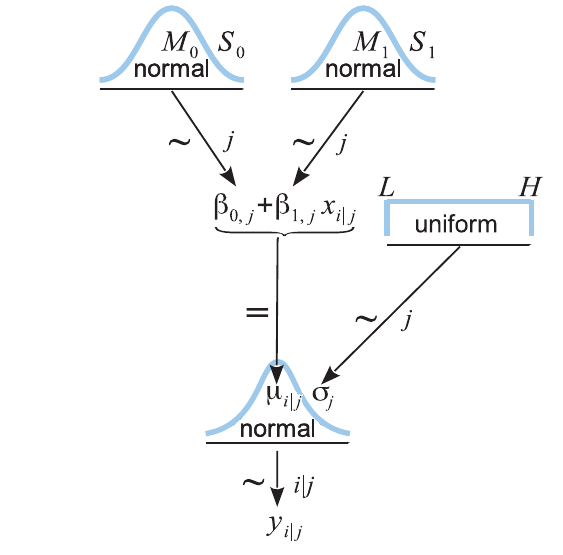

In [41]:
modelLC = '''                     // no more t, since data has shown to be quite normal
                                  // same same, but new ---v for categories 
data{
    int<lower=1> Ntotal;   
    int<lower=1> Ncateg;          // number of categories   
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal];               // the category of the data nomonkey=1 or monkey=2
}
transformed data{
    real unifLo;
    real unifHi; 
    real<lower=0> beta0sigma;     // one prior for all categories 
    real<lower=0> beta1sigma;     //   data is still "animals"
    real meanX;                   // data set marginal properties: mean
    real sdX;                     //                           and std
    real sdY;
    meanX = mean(x);              // estimate suitable priors by ourselves
    sdX = sd(x);                  // -"-
    sdY = sd(y);                  // -"-
    unifLo = sdY/1000;
    unifHi = sdY*1000; 
    beta1sigma = 10*fabs( sdY/sdX );        // set quite uninformed prior on
    beta0sigma = 10*fabs( meanX*sdY/sdX );  //   worst case of data distribution 
}
parameters{
    real beta0[Ncateg];           // intercept vector by category
    real beta1[Ncateg];           // gain      -"-
    real<lower=0> sigma[Ncateg];  // maybe different data scatter by category
}
model{
    sigma ~ uniform( unifLo, unifHi );          // vectorized
    beta0 ~ normal( 0, beta0sigma );            // -"-
    beta1 ~ normal( 0, beta1sigma );            // -"-
    for( i in 1:Ntotal ) {                      // categorized data (no vectorization)
        y[i] ~ normal( beta0[c[i]] + beta1[c[i]]*x[i], sigma[c[i]]); 
        // parameters        *             *                 *   according to category
    }
}
'''

#### model string (lower part)

```
// no more t, since data has shown to be quite normal
// same same, but new ---------------------v for categories 

parameters{
    real beta0[Ncateg];           // intercept vector by category
    real beta1[Ncateg];           // gain      -"-
    real<lower=0> sigma[Ncateg];  // maybe different data scatter by category
}
model{
    sigma ~ uniform( unifLo, unifHi );          // vectorized
    beta0 ~ normal( 0, beta0sigma );            // -"-
    beta1 ~ normal( 0, beta1sigma );            // -"-
    for( i in 1:Ntotal ) {                      // categorized data (no vectorization)
        y[i] ~ normal( beta0[c[i]] + beta1[c[i]]*x[i], sigma[c[i]]); 
        // parameters        *             *                 *   according to category
    }
}
```

#### model string (upper part)

```
data{
    int<lower=1> Ntotal;   
    int<lower=1> Ncateg;          // number of categories   
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal];               // the category of the data nomonkey=1 or monkey=2
}
transformed data{
    real unifLo;
    real unifHi; 
    real<lower=0> beta0sigma;     // one prior for all categories 
    real<lower=0> beta1sigma;     //   data is still "animals"
    real meanX;                   // data set marginal properties: mean
    real sdX;                     //                           and std
    real sdY;
    meanX = mean(x);              // estimate suitable priors by ourselves
    sdX = sd(x);                  // -"-
    sdY = sd(y);                  // -"-
    unifLo = sdY/1000;
    unifHi = sdY*1000; 
    beta1sigma = 10*fabs( sdY/sdX );        // set quite uninformed prior on
    beta0sigma = 10*fabs( meanX*sdY/sdX );  //   worst case of data distribution 
}
```

In [42]:
'''distinguish monkey data from other mammals'''
animalsdata['IsMonkey'] = 1 # new variable, initialize all mammals with 1
names = ['Man', 'Baboon', 'Chimpanzee', 'Gorilla', 'Owlmonkey', 
          'Patasmonkey', 'Rhesusmonkey', 'Galago' ] # list of old world monkeys
# locate and change them to "monkey"=2
animalsdata.loc[animalsdata['Species'].isin(names), 'IsMonkey'] = 2

In [43]:
dataLC = {
    'Ntotal': len(x),       # number of data; must be same for y
    'Ncateg': 2,            # number of categories: monkey&nomonkey
    'x':      animalsdata['log_BodyWt'].values,
    'y':      animalsdata['log_BrainWt'].values,
    'c':      animalsdata['IsMonkey'].values # category: nomonkey=1 & monkey=2
}

In [44]:
'''ready to fit Linear model with Categories'''
stanmdlLC = pystan.StanModel(model_code=modelLC, model_name='categorial')
fitLC = stanmdlLC.sampling(data=dataLC, iter=7000, warmup=2500, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL categorial_1eb2a211a886add8f662610f320ffa2a NOW.


In [45]:
print(fitLC)

Inference for Stan model: categorial_1eb2a211a886add8f662610f320ffa2a.
4 chains, each with iter=7000; warmup=2500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta0[0]   0.87  2.9e-4   0.04    0.8   0.84   0.87   0.89   0.94  14887    1.0
beta0[1]   1.41  2.5e-3   0.21    1.0    1.3   1.41   1.53   1.83   6935    1.0
beta1[0]   0.74  2.0e-4   0.02   0.69   0.72   0.74   0.75   0.79  14627    1.0
beta1[1]   0.72  1.8e-3   0.15   0.42   0.64   0.72   0.81   1.03   6885    1.0
sigma[0]   0.25  2.2e-4   0.03    0.2   0.23   0.24   0.26    0.3  12871    1.0
sigma[1]   0.38  2.0e-3   0.16    0.2   0.28   0.35   0.44   0.79   6290    1.0
lp__      51.66    0.03   2.04  46.62  50.62  52.07  53.17  54.41   5699    1.0

Samples were drawn using NUTS at Mon Jul  9 08:19:11 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reducti

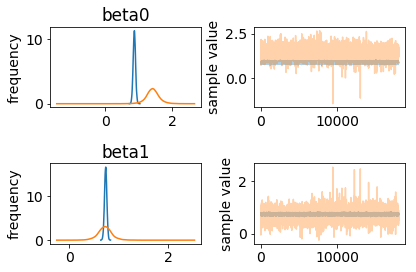

In [46]:
'''posterior for parameter vectors'''
f = fitLC.plot(['beta0', 'beta1'])
plt.tight_layout();

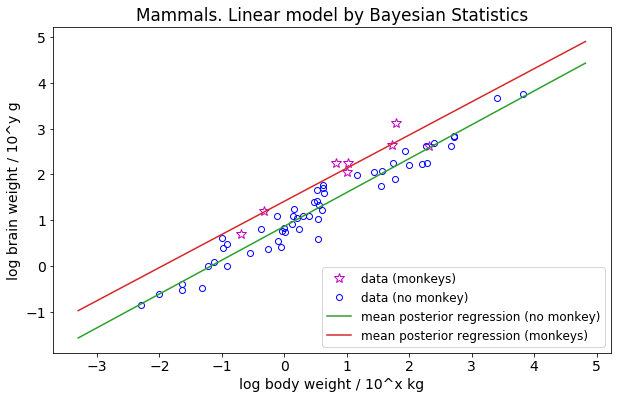

In [47]:
'''graphical result - categories monkeys & non-monkeys'''
f = plt.figure(figsize=(10, 6))
# show data
# show data
plt.plot(animalsdata['log_BodyWt'].loc[animalsdata['IsMonkey']==2], 
         animalsdata['log_BrainWt'].loc[animalsdata['IsMonkey']==2],
         '*', label='data (monkeys)', markeredgewidth=1,
         markeredgecolor='m', markerfacecolor='None', markersize=10)
plt.plot(animalsdata['log_BodyWt'].loc[animalsdata['IsMonkey']==1], 
         animalsdata['log_BrainWt'].loc[animalsdata['IsMonkey']==1],
         'o', label='data (no monkey)', markeredgewidth=1,
         markeredgecolor='b',markerfacecolor='None')

# get chains
xx = np.asarray([x.min()-1, x.max()+1]) # list of corners for straight line
# cycle through the two categories
for c, cname in enumerate(['no monkey', 'monkeys']):
    beta0 = fitLC.extract()['beta0'][:, c].mean()
    beta1 = fitLC.extract()['beta1'][:, c].mean()
    plt.plot(xx, beta0 + beta1*xx,
             label='mean posterior regression ('+cname+')')

# Labels
plt.title('Mammals. Linear model by Bayesian Statistics')
plt.xlabel('log body weight / 10^x kg')
plt.ylabel('log brain weight / 10^y g')
plt.legend(loc='lower right', fontsize=12);

## Ergebnis 4) Lineares Modell mit Kategorien

#### PyStan

               mean se_mean     sd     2.5%    25%    50%    75%  97.5%    n_eff   Rhat
    beta0[0]   0.87  3.1e-4   0.04     0.80   0.84   0.87   0.89   0.94    13494    1.0
    beta0[1]   1.41  2.2e-3   0.20     1.02   1.30   1.41   1.53   1.81     8347    1.0
    beta1[0]   0.74  2.1e-4   0.02     0.69   0.72   0.74   0.75   0.79    12798    1.0
    beta1[1]   0.72  1.5e-3   0.15     0.43   0.64   0.72   0.81   1.01     9453    1.0
    sigma[0]   0.25  2.2e-4   0.03     0.20   0.23   0.24   0.26   0.30    13475    1.0
    sigma[1]   0.38  2.0e-3   0.16     0.20   0.28   0.34   0.43   0.78     6577    1.0

#### Vergleich mit GLM

                          coef    std err          z      P>|z|      [0.025      0.975]
    -----------------------------------------------------------------------------------
    Intercept           0.8670      0.035     24.496      0.000       0.798       0.936
    IsMonkey[T.yes]     0.5303      0.093      5.698      0.000       0.348       0.713
    log_BodyWt          0.7374      0.023     31.802      0.000       0.692       0.783

$\Rightarrow$ sehr gute Übereinstimmung

# Beispiel 5: Hierarchisches Lineares Modell

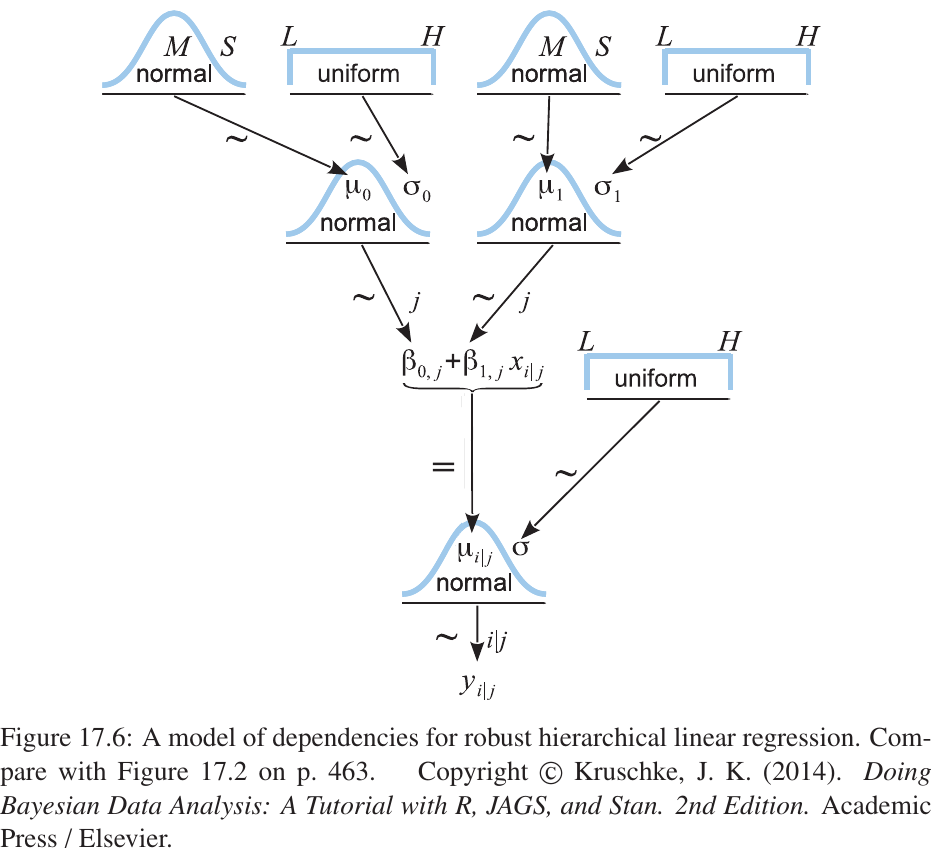

In [1]:
modelLCH = '''                         // Now, a hierarchical model
                                       // standardized version
data{
    int<lower=1> Ntotal;   
    int<lower=1> Ncateg;               // number of categories   
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal]; // the categories of the data points: nomonkey=1 or monkey=2
}
transformed data{                      // for standardization:
    real meanX;                        // data set marginal properties: mean x
    real meanY;                        //                                    y
    real sdX;                          //                            and std x
    real sdY;                          //                                    y 
    real zx[Ntotal];                   // standardized variables x
    real zy[Ntotal];                   //                        y
    
    meanX = mean(x);                   // compute properties for standardization
    meanY = mean(y); 
    sdX = sd(x); 
    sdY = sd(y);  
    for ( i in 1:Ntotal ) {            // compute the standardization
        zx[i] = ( x[i] - meanX ) / sdX;
        zy[i] = ( y[i] - meanY ) / sdY;
    }
}
parameters{
    real          zbeta0[Ncateg];      // intercept vector by category
    real          zbeta1[Ncateg];      // gain      -"-
    real<lower=0> zsigma;              // common variation each category
    real          zbeta0mu;
    real          zbeta1mu;
    real<lower=0> zbeta0sigma;
    real<lower=0> zbeta1sigma;
}
transformed parameters{ // backtransformation from standardized to original scaling
    real beta0[Ncateg];
    real beta1[Ncateg];
    real sigma;
    real beta0mu;
    real beta1mu;
    beta1mu = zbeta1mu * sdY / sdX;
    beta0mu = zbeta0mu * sdY  + meanY - zbeta1mu * meanX * sdY / sdX;
    sigma = zsigma * sdY;
    for ( j in 1:Ncateg ) {
        beta1[j] = zbeta1[j] * sdY / sdX;
        beta0[j] = zbeta0[j] * sdY  + meanY - zbeta1[j] * meanX * sdY / sdX; 
    }
}
model{
    zbeta0mu ~ normal( 0.0, 10 ); // we expect any offset, broadly distributed
    zbeta1mu ~ normal( 0.0, 10 ); // we expect standardized gain=+1, broadly 
    zbeta0sigma ~ uniform( 0.001, 1000 );   // broadly distributed
    zbeta1sigma ~ uniform( 0.001, 1000 );   // broadly distributed
    zsigma ~ uniform( 0.001, 1000 );

    for ( j in 1:Ncateg ) {
        zbeta0[j] ~ normal( zbeta0mu, zbeta0sigma );// the intermediate hierarchical level
        zbeta1[j] ~ normal( zbeta1mu, zbeta1sigma );// distribution of whole group
    }
    for( i in 1:Ntotal ) {                            // categorized data (no vectorization)
        zy[i] ~ normal( zbeta0[c[i]] + zbeta1[c[i]]*zx[i], zsigma); 
        // parameters          *              *       according to category
    }
}
'''

#### model string - hierarchical - upper part

```
// standardized version, easier to model
data{                                  // the same`
    int<lower=1> Ntotal; 
    int<lower=1> Ncateg; 
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal]; 
}
transformed data{                      // for standardization:
    real meanX;                        // data set marginal properties: mean x
    real meanY;                        //                                    y
    real sdX;                          //                            and std x
    real sdY;                          //                                    y 
    real zx[Ntotal];                   // standardized variables x
    real zy[Ntotal];                   //                        y

    meanX = mean(x);                   // compute properties for standardization
    meanY = mean(y); 
    sdX = sd(x); 
    sdY = sd(y);  
    for ( i in 1:Ntotal ) {            // compute the standardization
        zx[i] = ( x[i] - meanX ) / sdX;
        zy[i] = ( y[i] - meanY ) / sdY;
    }
}
```

#### model string - hierarchical - upper part

```
// standardized version, easier to model
data{                                  // the same
    int<lower=1> Ntotal; 
    int<lower=1> Ncateg; 
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal]; 
}
transformed data{                      // for standardization:
    real meanX;                        // data set marginal properties: mean x
    real meanY;                        //                                    y
    real sdX;                          //                            and std x
    real sdY;                          //                                    y 
    real zx[Ntotal];                   // standardized variables x
    real zy[Ntotal];                   //                        y

    meanX = mean(x);                   // compute properties for standardization
    meanY = mean(y); 
    sdX = sd(x); 
    sdY = sd(y);  
    for ( i in 1:Ntotal ) {            // compute the standardization
        zx[i] = ( x[i] - meanX ) / sdX;
        zy[i] = ( y[i] - meanY ) / sdY;
    }
}
```

#### model string - hierarchical - middle part

```
parameters{                            // for standardized variables
    real          zbeta0[Ncateg];      // intercept vector by category
    real          zbeta1[Ncateg];      // gain      -"-
    real<lower=0> zsigma;              // common variation each category
    real          zbeta0mu;
    real          zbeta1mu;
    real<lower=0> zbeta0sigma;
    real<lower=0> zbeta1sigma;
}
transformed parameters{                // backtransformation from standardized to original scaling
    real beta0[Ncateg];
    real beta1[Ncateg];
    real sigma;
    real beta0mu;
    real beta1mu;
    beta1mu = zbeta1mu * sdY / sdX;
    beta0mu = zbeta0mu * sdY  + meanY - zbeta1mu * meanX * sdY / sdX;
    sigma = zsigma * sdY;
    for ( j in 1:Ncateg ) {
        beta1[j] = zbeta1[j] * sdY / sdX;
        beta0[j] = zbeta0[j] * sdY  + meanY - zbeta1[j] * meanX * sdY / sdX; 
    }
}
```

#### model string - hierarchical - lower part

```
model{
    zbeta0mu ~ normal( 0.0, 10 );       // we expect any offset, broadly distributed
    zbeta1mu ~ normal( 0.0, 10 );       // we expect standardized gain=+1, broadly 
    zbeta0sigma ~ uniform( 0.001, 1000 );// broadly distributed
    zbeta1sigma ~ uniform( 0.001, 1000 );   
    zsigma      ~ uniform( 0.001, 1000 );

    for ( j in 1:Ncateg ) {
        // the intermediate hierarchical level
        zbeta0[j] ~ normal( zbeta0mu, zbeta0sigma );
        // distribution of whole group
        zbeta1[j] ~ normal( zbeta1mu, zbeta1sigma );
    }
    for( i in 1:Ntotal ) {            // categorized data (no vectorization)
        zy[i] ~ normal( zbeta0[c[i]] + zbeta1[c[i]]*zx[i], zsigma); 
        // parameters          *              *       according to category
    }
}
```

In [49]:
'''ready to fit'''
stanmdlLCH = pystan.StanModel(model_code=modelLCH, model_name='hierarchical')
fitLCH = stanmdlLCH.sampling(data=dataLC, iter=7000, warmup=2500,
                             chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hierarchical_4f67721351a38e8c87c131c9a3c42088 NOW.


In [50]:
print(fitLCH)

Inference for Stan model: hierarchical_4f67721351a38e8c87c131c9a3c42088.
4 chains, each with iter=7000; warmup=2500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
zbeta0[0]    -0.06  5.3e-4   0.03  -0.13  -0.08  -0.06  -0.04-9.5e-4   3461    1.0
zbeta0[1]     0.43  1.9e-3   0.09   0.25   0.37   0.43   0.49   0.61   2204    1.0
zbeta1[0]     0.94  4.7e-4   0.03   0.88   0.92   0.94   0.96    1.0   4177    1.0
zbeta1[1]     0.93  2.3e-3   0.11    0.7   0.85   0.93    1.0   1.15   2384    1.0
zsigma        0.24  3.4e-4   0.02    0.2   0.22   0.24   0.25   0.29   4162    1.0
zbeta0mu      0.27     0.1   4.63 -10.22  -0.83   0.17   1.34  11.26   2185    1.0
zbeta1mu      0.66    0.07   4.23 -10.16   0.09   0.91   1.48  10.09   4204    1.0
zbeta0sigma  15.36    0.92  54.06   0.23   0.88   2.88  10.12  106.7   3435    1.0
zbeta1sigma  12.82    0.67  48.69   0.09   0.43   1.75   7.51

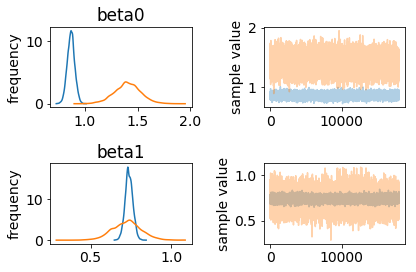

In [51]:
fig = fitLCH.plot(['beta0', 'beta1'])
plt.tight_layout();

### Vergleich kategoriales Lineares Modell - hierarchisches Lineares Modell'''

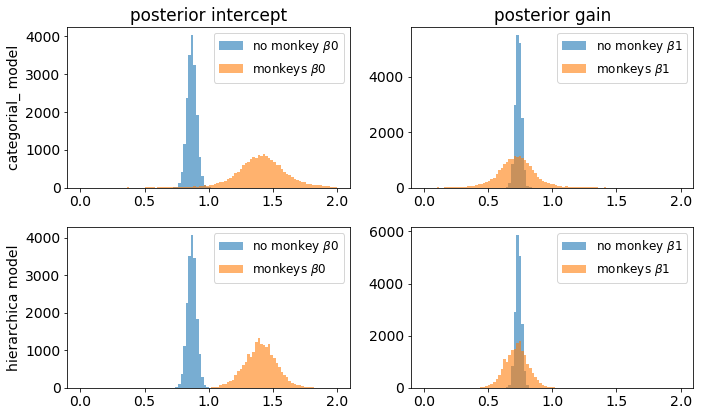

In [52]:
'''compare Linear Model with its hierarchical version'''
fig = plt.figure(figsize=(10, 6))
bins = np.linspace(0.0, 2.0, 101)

ntitle = ['intercept', 'gain']
for im, mdl in enumerate([fitLC, fitLCH]):
    for ib, betaN in enumerate(['beta0', 'beta1']):
        fig.add_subplot(2, 2, 1+2*im+ib)
        if im==0:
            plt.title('posterior '+ntitle[ib])
        if ib==0:
            plt.ylabel(mdl.model_name[:11]+' model')
        for ic, categ in enumerate(['no monkey', 'monkeys']):
            plt.hist(mdl.extract()[betaN][:, ic], bins=bins, alpha=.6,
                     label=categ+' $\\beta${}'.format(ib))
            plt.legend(fontsize=12)
plt.tight_layout();

In [53]:
'''difference of hierarchical model'''

print('95% HDI of beta0 for      mammals           monkeys')
print('non hierarchical model ', 
      np.round(bayes.HDIofMCMC(fitLC.extract()['beta0'][:, 0]), decimals=4), 
      np.round(bayes.HDIofMCMC(fitLC.extract()['beta0'][:, 1]), decimals=4))
print('hierarchical model     ', 
      np.round(bayes.HDIofMCMC(fitLCH.extract()['beta0'][:, 0]), decimals=4), 
      np.round(bayes.HDIofMCMC(fitLCH.extract()['beta0'][:, 1]), decimals=4))

95% HDI of beta0 for      mammals           monkeys
non hierarchical model  [0.7952 0.9371] [1.0057 1.8321]
hierarchical model      [0.7976 0.9368] [1.1426 1.6373]


In [54]:
'''why do we have low ESS? 0) get one example chain (e.g. index 0)'''
varnames = list(fitLCH.flatnames)
print(varnames)
chains = fitLCH.extract(permuted=False) # now ndarray with separate chains
print(chains.shape, type(chains))

['zbeta0[0]', 'zbeta0[1]', 'zbeta1[0]', 'zbeta1[1]', 'zsigma', 'zbeta0mu', 'zbeta1mu', 'zbeta0sigma', 'zbeta1sigma', 'beta0[0]', 'beta0[1]', 'beta1[0]', 'beta1[1]', 'sigma', 'beta0mu', 'beta1mu']
(4500, 4, 17) <class 'numpy.ndarray'>


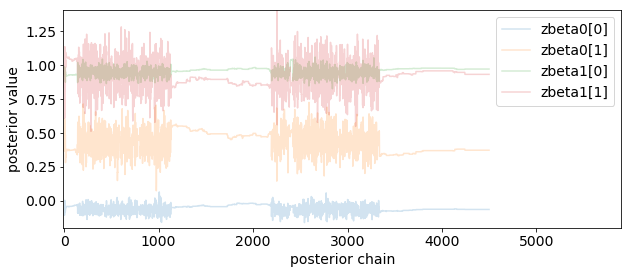

In [62]:
'''why do we have low ESS?  1) regression parameters beta'''
fig = plt.figure(figsize=(10, 4))
for i in range(4): # first of 4 chains of 4 low level parameters 
    plt.plot(chains[:, 0, i], alpha=.2, label=varnames[i]) 
plt.ylim(-0.2, 1.4)
plt.xlim(-10, 5900)
plt.xlabel('posterior chain')
plt.ylabel('posterior value')
plt.legend(loc='upper right', fontsize=12);

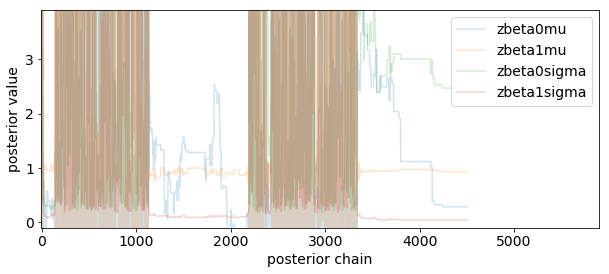

In [63]:
'''why do we have low ESS?  2) hierarchical parameters'''
fig = plt.figure(figsize=(10, 4))
for i in range(5,9): # first of 4 chains of top level parameters 
    plt.plot(chains[:,0,i], alpha=.2, label=varnames[i])
plt.ylim(-0.1, 3.9)
plt.xlim(-10, 5900)
plt.xlabel('posterior chain')
plt.ylabel('posterior value')
plt.legend(loc='upper right', fontsize=12);

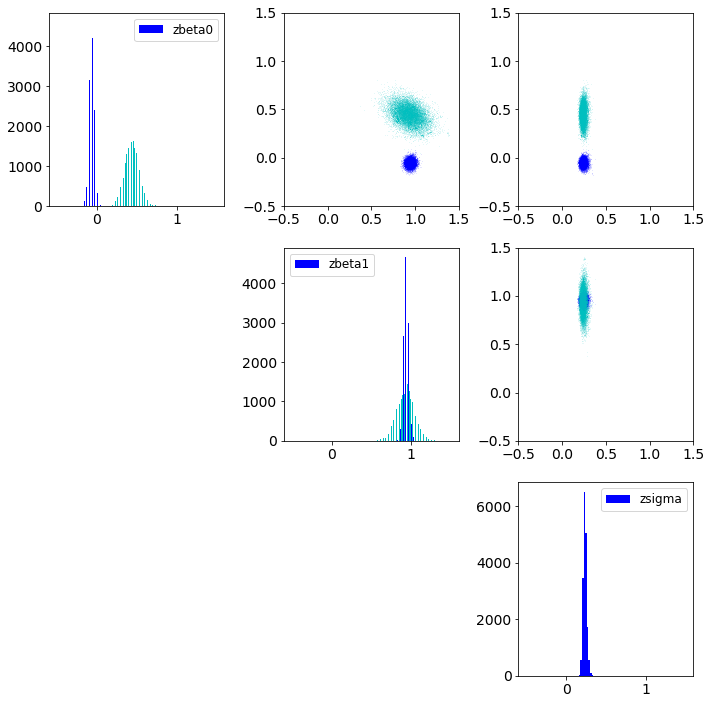

In [58]:
'''dependencies between parameters 1) beta0, beta1 and sigma'''
A = fitLCH.extract() # get "collection" of posteriors, including names
vs = list(A.keys())[0:3] # 0:7 are all z   0:3 are zbeta0 zbeta1 and zsigma
LL = len(vs)   # number of parameters of interest
fig = plt.figure(figsize=(10, 10))
X1, X2 = (-0.5, 1.5)
bins = np.linspace(X1, X2, 101)
for i, ni in enumerate(vs):
    fig.add_subplot(LL, LL, 1+i*(LL+1)) # diagonal: marginal histogram
    plt.hist(A[ni], bins=bins, label=ni, color=['b', 'c'][:len(A[ni].shape)])
    plt.legend(fontsize=12)
    for j, nj in enumerate(vs[i+1:]):
        fig.add_subplot(LL, LL, 1+i*(LL+1)+j+1)  # side: joint distribution
        plt.axis((X1, X2, X1, X2))
        if len(A[nj].shape)==1: # only one value? (like sigma)
            plt.plot(A[nj], A[ni][:,0], 'b,', alpha=.1) # same in category
            plt.plot(A[nj], A[ni][:,1], 'c,', alpha=.1)
        else:
            # different in category
            plt.plot(A[nj][:,0], A[ni][:,0], 'b,', alpha=.1)
            plt.plot(A[nj][:,1], A[ni][:,1], 'c,', alpha=.1)
plt.tight_layout(); # non overlapping titles, axis numbers and labels

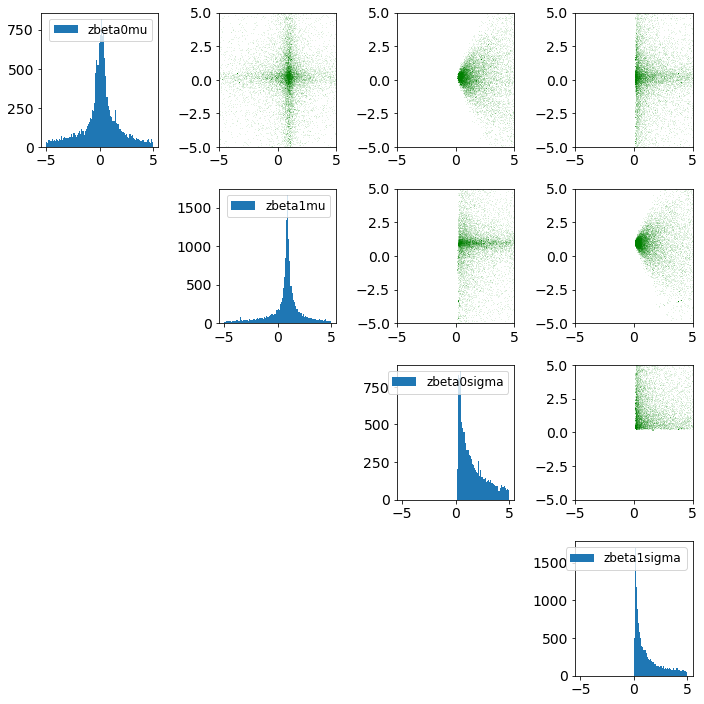

In [59]:
'''dependencies between parameters 2) higher level betaXmu, betaXsigma'''
fig = plt.figure(figsize=(10, 10))
X1, X2 = (-5., +5.)
bins = np.linspace(X1, X2, 101)
vs = list(A.keys())[3:7] # 0:7 are all z   0:3 are zbeta0 zbeta1 and zsigma
LL = len(vs)
for i, ni in enumerate(vs):
    fig.add_subplot(LL, LL, 1+i*(LL+1))          # diagonal
    plt.hist(A[ni], bins=bins, label=ni)
    plt.legend(fontsize=12)
    for j, nj in enumerate(vs[i+1:]):
        fig.add_subplot(LL, LL, 1+i*(LL+1)+j+1)  # side
        plt.axis((X1, X2, X1, X2))
        plt.plot(A[nj], A[ni], 'g,', alpha=.1)
plt.tight_layout();

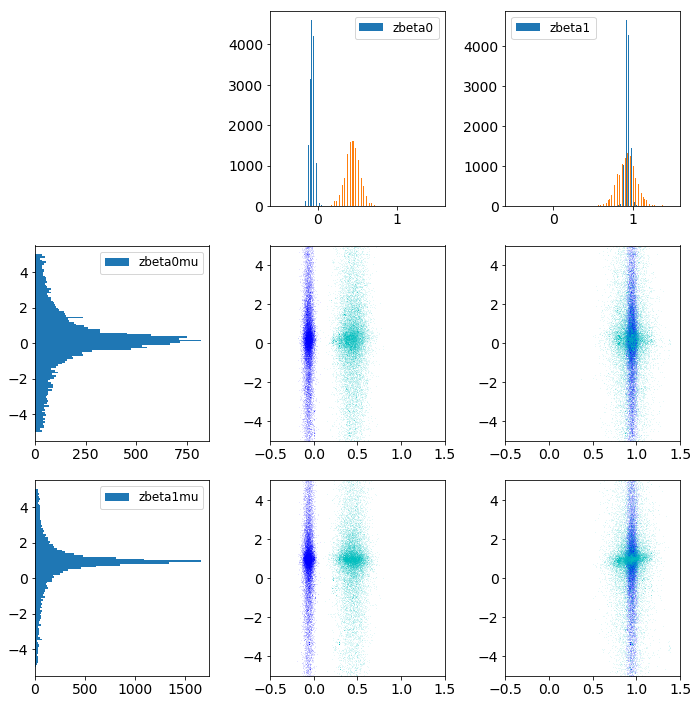

In [60]:
'''dependencies between parameters 3) lower and higher level betaX, betaXmu'''
fig = plt.figure(figsize=(10, 10))
X1i, X2i, X1j, X2j = (-.5, 1.5, -5, +5)       # i: z variable  j: high level
bini = np.linspace(X1i, X2i, 101)
binj = np.linspace(X1j, X2j, 101)
vi = list(A.keys())[:2] # 0, 1 are zbeta0 zbeta1
# 3, 4 are higher hierarchical level zbeta0-mu, zbeta1-mu
vj = list(A.keys())[3:5]
LI = len(vi)
LJ = len(vj)
for i, ni in enumerate(vi):
    fig.add_subplot(LJ+1, LI+1, 2+i) # top line: histo i, skip first
    plt.hist(A[ni], bins=bini, label=ni)
    plt.legend(fontsize=12)
    for j, nj in enumerate(vj):
        fig.add_subplot(LJ+1, LI+1, 2+i + (LI+1)*(j+1))
        plt.axis((X1i, X2i, X1j, X2j))
        plt.plot(A[ni][:,0], A[nj], 'b,', alpha=.1)
        plt.plot(A[ni][:,1], A[nj], 'c,', alpha=.1)
for j, nj in enumerate(vj):
    fig.add_subplot(LJ+1, LI+1, 1+(LI+1)*(j+1))   # left column: histogram i
    plt.hist(A[nj], bins=binj, label=nj, orientation="horizontal")
    plt.legend(fontsize=12)
plt.tight_layout();

## Ergebnis 5) Hierarchisches Lineares Modell

#### Parametervektor

Die Parameter werden durch den Posterior gut geschätzt
- Abstand zwischen $\beta_{0,j}$
- Steigung (war bereits ähnlich)
- Streuung $\sigma_{0,j}$ nähert sich an

#### Effekt durch Hierarchie

- Einschränkung von $\beta_{0, \text{monkey}}$

#### Kopplung

- *Kaum* Kopplung zwischen den Ebenen
- Große Streuung in *zbetamu*
    - große Freiheit für *beta* in jeder Kategorie
- Dennoch leichte Kopplung:
    - Einengung $\beta_{1, \text{monkey}}$

### Problem

- Es steckt kaum Information in den **nur 2** Kategorien
- die obere Hierarchieebene wird gar nicht ausgenutzt
    - zu viele Freiheitsgrade
- beta0sigma und beta1sigma sind daher beliebig
- beta0mu und beta1mu sind ebenfalls sehr breit verteilt

#### Folge

- Hamiltonian MCMC Posterior-Spaziergang stößt an Rand der Verteilung
    - Gradient nicht mehr stetig
    - Ablehnung von Sprüngen

#### Warn-Meldung

Informational Message:
The current Metropolis proposal is about to be rejected because of the following issue:
Exception thrown at line 62: normal_log: Scale parameter is 0, but must be > 0!
If this warning occurs sporadically, such as for highly constrained variable types like 
covariance matrices, then the sampler is fine, but if this warning occurs often then your
model may be either severely ill-conditioned or misspecified.

### Lösung des Problems

- Mehr Daten nötig
    - Anzahl der Kategorien $\geq$ Anzahl Parameter in oberster Hierarchieebene
    - Elephanten, Affen, Nagetiere, Katzen, ...

#### Anderes Beispiel

- Gruppe von Versuchspersonen
    - Versuchspersonen als (ähnliche, aber leicht unterschiedliche) Individuen (*j*)
    - individuelle Einzelergebnisse (*i*)

# Beispiel 6: Mehrere Kategorien in Hierarchischem Modell


In [62]:
'''data from Kruschke book, chapter 17'''
kdata = pd.read_csv('KruschkePrograms/HierLinRegressData.csv', sep=',')
kdata.head(8)

,Subj,X,Y
0,1,60.2,145.6
1,1,61.5,157.3
2,1,61.7,165.6
3,1,62.3,158.8
4,1,67.6,196.1
5,1,69.2,183.9
6,2,53.7,165.0
7,2,60.1,166.9


correlation coefficient (over all) C_XY=0.103 with p-value=0.242 


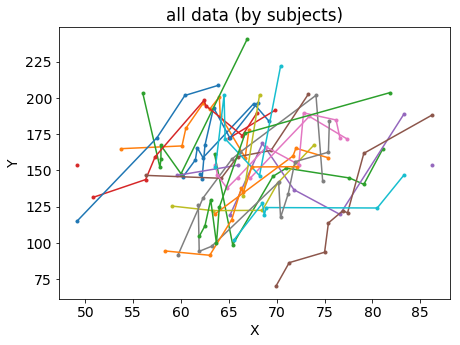

In [63]:
'''show data: for each individual Y depends on X'''
fig = plt.figure(figsize=(7, 5))
subjects = kdata.groupby('Subj') # pandas conveniently allows separation
for name, subj in subjects:
    # label not used, legend too long
    plt.plot(subj.X, subj.Y, marker='o', linestyle='-', ms=3, label=name)
plt.title('all data (by subjects)')
plt.xlabel('X')
plt.ylabel('Y')
# Pearson correlation coeff and test against H0: C=0
C, p = stats.pearsonr(kdata['X'], kdata['Y'])
print('correlation coefficient (over all) C_XY={:.3f} with p-value={:.3f} '
                      .format(C, p))

In [64]:
dataLCHK = {
    'Ntotal': len(kdata),       # number of data; must be same for y
    'Ncateg': len(subjects),    # number of categories: monkey&nomonkey
    'x':      kdata['X'].values,
    'y':      kdata['Y'].values,
    'c':      kdata['Subj'].values   # categories = subjects
}

In [65]:
dataLCHK

{'Ntotal': 132,
 'Ncateg': 25,
 'x': array([60.2, 61.5, 61.7, 62.3, 67.6, 69.2, 53.7, 60.1, 60.5, 62.3, 63. ,
        64. , 64.1, 66.7, 67.1, 63.5, 65.4, 69.6, 71. , 77.6, 79.1, 81.1,
        65. , 69.8, 65.1, 68.5, 71.8, 76.6, 83.3, 69.9, 71.3, 75. , 75.4,
        76.9, 77.4, 79.1, 86.2, 67.2, 73.4, 77.3, 59.7, 62.3, 65.3, 66.2,
        74.1, 74.8, 59.1, 63.3, 68.5, 70.1, 73.9, 65.5, 68.5, 68.7, 68.9,
        80.5, 83.3, 62. , 62.2, 62.5, 63.4, 65.1, 68. , 63.6, 71.7, 72. ,
        75.4, 56. , 57.8, 57.9, 57.9, 60. , 66.9, 50.8, 56.3, 57.3, 62.4,
        62.6, 66.4, 67.9, 59.6, 66. , 56.3, 64.2, 65.9, 69.4, 73.3, 63.6,
        63.8, 64.8, 65.9, 68.9, 72.3, 72.8, 76.2, 76.6, 61.8, 61.9, 63.2,
        70.2, 70.4, 71.2, 71.9, 75.4, 75.5, 66.5, 68.2, 63.6, 64.5, 64.6,
        68.2, 70.4, 49.1, 57.5, 60.4, 63.9, 58.3, 63. , 65.3, 66.3, 66.5,
        67.4, 72.1, 61.9, 62.5, 63.1, 63.7, 64. , 66.7, 81.8, 49.1, 86.2]),
 'y': array([145.6, 157.3, 165.6, 158.8, 196.1, 183.9, 165. , 166.9, 179. 

In [66]:
modelLCHK = ''' // same as before, but now, a hierarchical model with lots of categories
data{
    int<lower=1> Ntotal;   
    int<lower=1> Ncateg; // number of categories   
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal];// the categories of the data points: nomonkey=1 or monkey=2
}
transformed data{        // for standardization:
    real meanX;          // data set marginal properties: mean x
    real meanY;          //                                    y
    real sdX;            //                            and std x
    real sdY;            //                                    y 
    real zx[Ntotal];     // standardized variables x
    real zy[Ntotal];     //                        y
    
    meanX = mean(x);     // compute properties for standardization
    meanY = mean(y); 
    sdX = sd(x); 
    sdY = sd(y);  
    for ( i in 1:Ntotal ) { // compute the standardization
        zx[i] = ( x[i] - meanX ) / sdX;
        zy[i] = ( y[i] - meanY ) / sdY;
    }
}
parameters{
    real          zbeta0[Ncateg];      // intercept vector by category
    real          zbeta1[Ncateg];      // gain      -"-
    real<lower=0> zsigma;              // common variation each category
    real          zbeta0mu;
    real          zbeta1mu;
    real<lower=0> zbeta0sigma;
    real<lower=0> zbeta1sigma;
}
transformed parameters{ // backtransformation from standardized to original scaling
    real beta0[Ncateg];
    real beta1[Ncateg];
    real sigma;
    real beta0mu;
    real beta1mu;
    beta1mu = zbeta1mu * sdY / sdX;
    beta0mu = zbeta0mu * sdY  + meanY - zbeta1mu * meanX * sdY / sdX;
    sigma = zsigma * sdY;
    for ( j in 1:Ncateg ) {
        beta1[j] = zbeta1[j] * sdY / sdX;
        beta0[j] = zbeta0[j] * sdY  + meanY - zbeta1[j] * meanX * sdY / sdX; 
    }
}
model{
    zbeta0mu ~ normal( 0.0, 10 );           // we expect any offset, broadly distributed
    zbeta1mu ~ normal( 0.0, 10 );           // we expect standardized gain=+1, broadly 
    zbeta0sigma ~ uniform( 0.001, 1000 );   // broadly distributed
    zbeta1sigma ~ uniform( 0.001, 1000 );   // broadly distributed
    zsigma ~ uniform( 0.001, 1000 );

    for ( j in 1:Ncateg ) {
        zbeta0[j] ~ normal( zbeta0mu, zbeta0sigma );  // the intermediate hierarchical level
        zbeta1[j] ~ normal( zbeta1mu, zbeta1sigma );  // distribution of whole group
    }
    for( i in 1:Ntotal ) {                            // categorized data (no vectorization)
        zy[i] ~ normal( zbeta0[c[i]] + zbeta1[c[i]]*zx[i], zsigma); 
        // parameters          *              *       according to category
    }
}
'''

### model string

```
modelLCHK = '''// same as before, but now, a hierarchical model with lots of categories
data{
    int<lower=1> Ntotal;   
    int<lower=1> Ncateg;    // number of categories   
    real x[Ntotal];
    real y[Ntotal];
    int  c[Ntotal];   // the categories of the data points: nomonkey=1 or monkey=2
}
transformed data{           // for standardization:
    real meanX;             // data set marginal properties: mean x
    real meanY;             //                                    y
    real sdX;               //                            and std x
    real sdY;               //                                    y 
    real zx[Ntotal];        // standardized variables x
    real zy[Ntotal];        //                        y

    meanX = mean(x);        // compute properties for standardization
    meanY = mean(y); 
    sdX = sd(x); 
    sdY = sd(y);  
    for ( i in 1:Ntotal ) { // compute the standardization
        zx[i] = ( x[i] - meanX ) / sdX;
        zy[i] = ( y[i] - meanY ) / sdY;
    }
}
parameters{
    real          zbeta0[Ncateg]; // intercept vector by category
    real          zbeta1[Ncateg]; // gain      -"-
    real<lower=0> zsigma;         // common variation each category
    real          zbeta0mu;
    real          zbeta1mu;
    real<lower=0> zbeta0sigma;
    real<lower=0> zbeta1sigma;
}
// backtransformation from standardized to original scaling
transformed parameters{
    real beta0[Ncateg];
    real beta1[Ncateg];
    real sigma;
    real beta0mu;
    real beta1mu;
    beta1mu = zbeta1mu * sdY / sdX;
    beta0mu = zbeta0mu * sdY  + meanY - zbeta1mu * meanX * sdY / sdX;
    sigma = zsigma * sdY;
    for ( j in 1:Ncateg ) {
        beta1[j] = zbeta1[j] * sdY / sdX;
        beta0[j] = zbeta0[j] * sdY  + meanY - zbeta1[j] * meanX * sdY / sdX; 
    }
}
model{
    zbeta0mu ~ normal( 0.0, 10 ); // we expect any offset, broadly distributed
    zbeta1mu ~ normal( 0.0, 10 ); // we expect standardized gain=+1, broadly 
    zbeta0sigma ~ uniform( 0.001, 1000 );// broadly distributed
    zbeta1sigma ~ uniform( 0.001, 1000 );// broadly distributed
    zsigma ~ uniform( 0.001, 1000 );

    for ( j in 1:Ncateg ) {
        zbeta0[j] ~ normal( zbeta0mu, zbeta0sigma ); // the intermediate hierarchical level
        zbeta1[j] ~ normal( zbeta1mu, zbeta1sigma ); // distribution of whole group
    }
    for( i in 1:Ntotal ) { // categorized data (no vectorization)
        zy[i] ~ normal( zbeta0[c[i]] + zbeta1[c[i]]*zx[i], zsigma); 
        // parameters          *              *       according to category
    }
}'''
```

In [67]:
'''ready to fit'''
stanmdlLCHK = pystan.StanModel(model_code=modelLCHK, model_name='hierarchical')
fitLCHK = stanmdlLCHK.sampling(data=dataLCHK, iter=7000,
                               warmup=2500, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hierarchical_eaffe4d6901839f9da3bc52ec2f1ea8f NOW.


In [68]:
print(fitLCHK) 

Inference for Stan model: hierarchical_eaffe4d6901839f9da3bc52ec2f1ea8f.
4 chains, each with iter=7000; warmup=2500; thin=1; 
post-warmup draws per chain=4500, total post-warmup draws=18000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
zbeta0[0]     0.75  2.0e-3   0.27   0.23   0.57   0.75   0.93   1.28  18000    1.0
zbeta0[1]     1.16  2.9e-3   0.25   0.66    1.0   1.17   1.33   1.63   7384    1.0
zbeta0[2]    -0.63  3.5e-3   0.27  -1.15  -0.81  -0.63  -0.45   -0.1   5875    1.0
zbeta0[3]     0.74  3.0e-3    0.4  -0.06   0.47   0.74    1.0   1.54  18000    1.0
zbeta0[4]    -0.67  2.3e-3   0.31  -1.26  -0.88  -0.67  -0.47  -0.06  18000    1.0
zbeta0[5]    -2.11  6.4e-3   0.37  -2.89  -2.35  -2.09  -1.85  -1.43   3409    1.0
zbeta0[6]    -0.07  2.8e-3   0.37   -0.8  -0.32  -0.08   0.18   0.65  18000    1.0
zbeta0[7]    -0.15  1.8e-3   0.25  -0.63  -0.31  -0.15   0.02   0.33  18000    1.0
zbeta0[8]     -0.5  2.0e-3   0.27  -1.03  -0.69   -0.5  -0.32

### Ergebnis a) individuelle Versuchspersonen

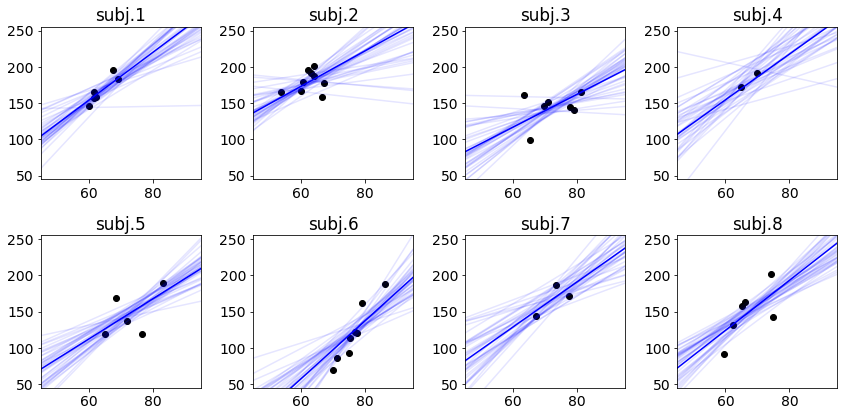

In [69]:
'''(FOR SLIDES)  show parts of all data'''
fig = plt.figure(figsize=(12, 6))
# random selection of beta[]
indices = np.random.choice(a=len(fitLCHK.extract()['sigma']),
                           size=40, replace=False, p=None)

img = 1
for i in range(8):                 # subjects of interest: first eight
    X = subjects.get_group(i+1).X  # subject numbers start at 1 
    Y = subjects.get_group(i+1).Y
    fig.add_subplot(2, 4, img)
    img += 1
    pbeta0 = fitLCHK.extract()['beta0'][:, i]
    pbeta1 = fitLCHK.extract()['beta1'][:, i]
    plt.plot(X, Y, 'ko')
    plt.title('subj.{}'.format(i+1))
    xx = np.asarray([41, 99])      # straight line between borders
    yy = pbeta0.mean() + pbeta1.mean()*xx # linear model function: mean 
    plt.plot(xx, yy, 'b-')
    for idx in indices:
        yy = pbeta0[idx] + pbeta1[idx]*xx # linear model function: examples
        plt.plot(xx, yy, 'b-', alpha=.1)
    plt.xlim(45, 95)
    plt.ylim(45, 255)
plt.tight_layout()

### Ergebnis b) Auswirkung auf die Gruppe

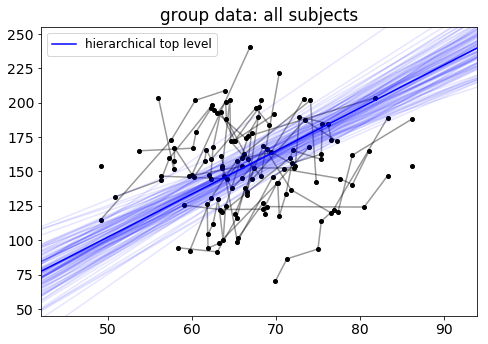

In [71]:
'''show all data with group effect'''
fig = plt.figure(figsize=(7, 5))
# random selection of beta[]
indices = np.random.choice(a=len(fitLCHK.extract()['sigma']),
                           size=100, replace=False, p=None)
for i, (name, subj) in enumerate(subjects):
    plt.plot(subj.X, subj.Y, 'ko', ms=4, label='')
    plt.plot(subj.X, subj.Y, 'k-', alpha=.4, label='')
pbeta0 = fitLCHK.extract()['beta0mu']
pbeta1 = fitLCHK.extract()['beta1mu']
xx = np.asarray([41, 94])             # straight line between borders
yy = pbeta0.mean() + pbeta1.mean()*xx # linear model function: mean of group
plt.plot(xx, yy, 'b-', label='hierarchical top level')
for idx in indices:
    # linear model function: examples of group
    yy = pbeta0[idx] + pbeta1[idx]*xx
    plt.plot(xx, yy, 'b-', alpha=.1)
plt.xlim(42, 94)
plt.ylim(45, 255)
plt.title('group data: all subjects')
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

### Ergebnis c) Rückwirkung auf Individuen

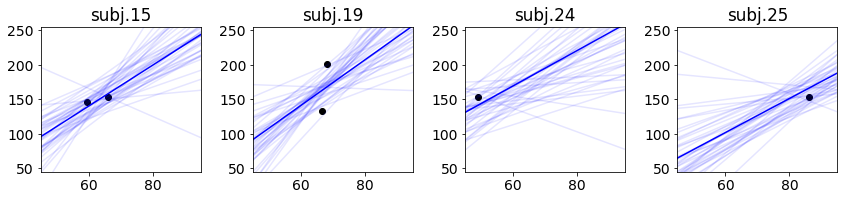

In [72]:
'''(FOR SLIDES)  show parts of all data'''
fig = plt.figure(figsize=(12, 3))
# random selection of beta[]
indices = np.random.choice(a=len(fitLCHK.extract()['sigma']),
                           size=40, replace=False, p=None)

img = 1
for i in [14, 18, 23, 24]:           # subjects of interest
    X = subjects.get_group(i+1).X    # subject numbers start at 1 
    Y = subjects.get_group(i+1).Y
    fig.add_subplot(1, 4, img)
    img += 1
    pbeta0 = fitLCHK.extract()['beta0'][:, i]
    pbeta1 = fitLCHK.extract()['beta1'][:, i]
    plt.plot(X, Y, 'ko')
    plt.title('subj.{}'.format(i+1))
    xx = np.asarray([41, 99])              # straight line between borders
    yy = pbeta0.mean() + pbeta1.mean()*xx  # linear model function: mean 
    plt.plot(xx, yy, 'b-')
    for idx in indices:
        yy = pbeta0[idx] + pbeta1[idx]*xx  # linear model function: examples
        plt.plot(xx, yy, 'b-', alpha=.1)
    plt.xlim(45, 95)
    plt.ylim(45, 255)
plt.tight_layout()

## Ergebnis 6) Hierarchische Modelle

- Individuen zeigen ähnliches Verhalten 
    - erlaubt sind (hier im Bsp.) individuelle Steigung und individuelles Level
- Hierarchisches Modell verbindet Individuen als Mitglieder der Gruppenpopulation
    - Summe der Individuen erlaubt Rückschlüsse auf Eigenschaften der Gruppe an sich
    - Gruppeneigenschaften erlauben Rückschlüsse auf einzelne Individuen
- Obacht
    - Anpassung nur möglich, wenn ausreichend Daten (hier Kategorien) verfügbar

# Fragen?

# *Generalisierte* Lineare Modelle

Bereits gesehen:
- Link Funktion in GLM
- Anwendung einer Link-Funktion mit Bayes-Statistik
    - Psychometrische Daten *logistische Regression*: Psignifit

Erweiterung des Linearen Modells
- Link Funktion

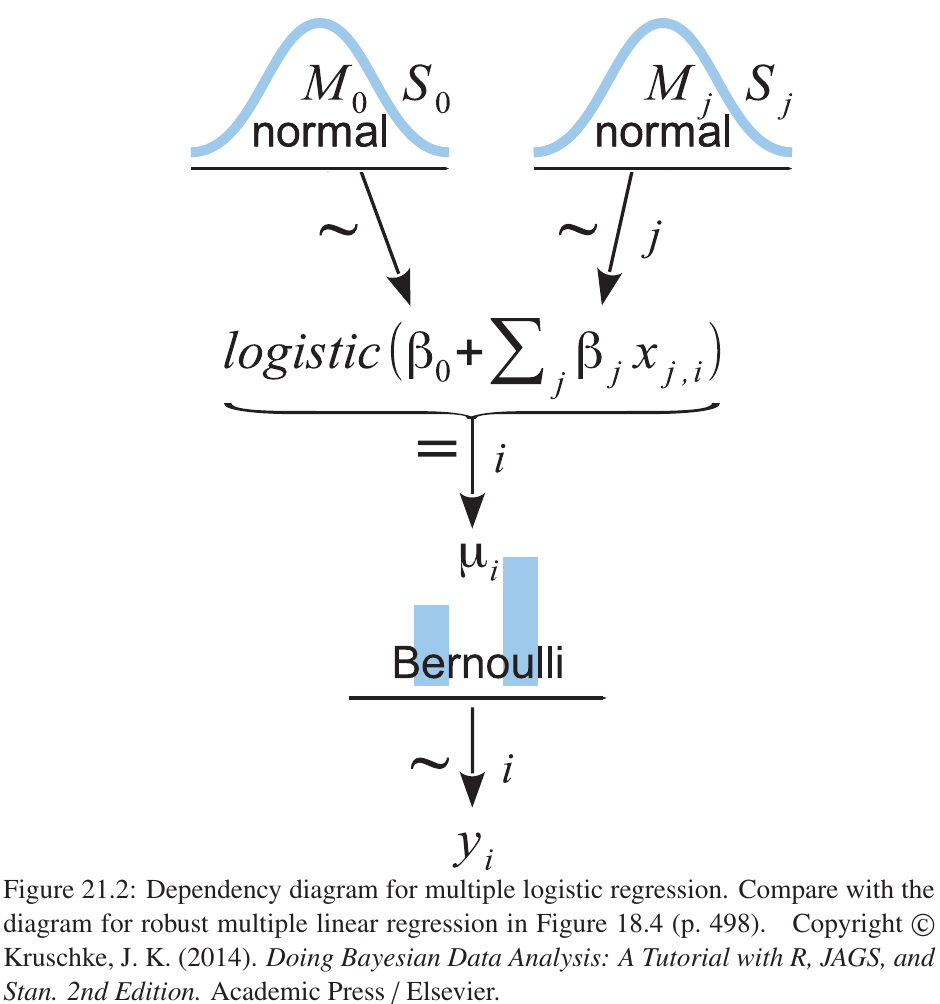

## Funktionen in Stan

#### Link-Funktionen

    logit(x)
    inv_logit(x)
    inv_cloglog(x)

#### Verteilungen

    y ~ bernoulli_logit( alpha + beta * x );
    y ~ bernoulli( inv_logit( alpha + beta * x[n] ) );
               # equivalent, but less efficient and less arithmetically stable

Siehe Stan-Manual Kap. 40

# Zusammenfassung GLM und Bayes-Statistik

- ***PyStan-MCMC***- und ***GLM-IRLS***-Ergebnisse stimmen sehr gut überein
- Methode der Wahl hängt von Zweck der Auswertung ab
- Vorteile durch Bayes-Statistik können ausgenutzt werden
    - Posterior-Verteilung der Zufallsvariablen des Parametervektors
    - Vergleich von Parametern
    - Zugriff auf übergeordnete Gruppenvariable in hierarchischem Modell
    - Einblicke in Verteilungen
- flexiblere Modelle möglich
- Berechnung aufwändiger

# Zusammenfassung PyStan

- `import pystan`
- *Modell-String* bildet kompletten Modellaufbau ab
    - `data{}` ; optional `transposed data{}`
    - `parameters{}` ;  optional `transposed parameters{}`
    - `model{}`
- Daten
    - als `dictionary`
    - Skalar, Vektor, Matrix
- Initialisieren und Kompilieren
    - `stanmodel = pystan.StanModel(model_code=..., ...)`
- Berechnen der Posterior-Markovketten
    - `fit = stanmodel.sampling(data=..., iter=..., warmup=..., chains=..., n_jobs=..., ...)`
- Ergebnis Posterior aller Parameter
    - Statistik mit `print(fit)`
    - Graphik mit `fit.plot(['param1', 'param2',...])`
    - Numerisch mit `fit.extract()`
- usw.
    - `fit.<TAB>`
    - `help(fit)`

# Literatur

#### Buch

- J. K. Kruschke: Doing Bayesian Data Analysis, 2nd. A Tutorial with R, JAGS and Stan. Academic Press (2015)

#### Links

- [Beispielprogramme zu Kruschke-Buch](https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/tree/master/2e)
- [Stan documentation](http://mc-stan.org/users/documentation/)
- [PyStan documentation](http://mc-stan.org/users/interfaces/pystan.html)
- [Stan's source-code repository](https://github.com/stan-dev/stan)
- [über die Wahl von Priors](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)
- [Schütt et.al.: Likelihood-Based Parameter Estimation and Comparison of Dynamical Cognitive Models (2017)](https://arxiv.org/pdf/1606.07309)

#### Software

- https://github.com/wichmann-lab/psignifit

- die erste Auflage Kruschke läßt sich im Internet als pdf finden....
- Wenn es nicht klappt: Email, dann pdf zu Schütt etal.

# Fragen?

# Dank an

- [Tom Wallis](https://tomwallis.info/about/)
- [Heiko Schütt](http://www.wsi.uni-tuebingen.de/lehrstuehle/neuronale-informationsverarbeitung/people/members/heiko-schuett-cv.html)

----